In [226]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [227]:
# @title **Load the Datasets**

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

# Load the file paths
file_paths = {
    "applied": "/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/1.11_Applied_by_Sector.xlsx",
    "approved": "/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/1.12_Approvals_by_Sector.xlsx",
    "disbursed": "/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/1.13_Disbursed_by_Sector.xlsx",
    "repaid": "/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/1.14_Repaid_by_Sector.xlsx",
    "outstanding": "/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/1.15_Outstanding_by_Sector.xlsx",
    "impaired": "/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/1.16_Impaired_by_Sector.xlsx"
}

# Define a cleaning function
def clean_data(file_path, skiprows=5):
    data = pd.read_excel(file_path, skiprows=skiprows)

    # Clean column names
    data.columns = data.columns.str.strip().str.replace(r'\n', '', regex=True)

    # Rename columns
    data.rename(columns={
    data.columns[0]: 'Year',
    data.columns[1]: 'Month'
    }, inplace=True)

    # Extract English labels from "Sector" column
    data['Sector'] = data['Sector'].str.split('/').str[1].str.strip()

    # Function to fill Year based on Month progression
    current_year = np.nan
    for i in range(len(data)):
        if not pd.isna(data.at[i, 'Year']):
            current_year = data.at[i, 'Year']
        elif not pd.isna(data.at[i, 'Month']):
            if data.at[i, 'Month'] == 1 and not pd.isna(current_year):
                current_year += 1
            data.at[i, 'Year'] = current_year

    # Function to propagate Year and Month values 4 rows upward
    for i in range(len(data)):
        if (data.at[i, 'Sector'] == 'Total' and
            pd.notna(pd.to_numeric(data.at[i, 'Month'], errors='coerce')) and
            pd.notna(pd.to_numeric(data.at[i, 'Year'], errors='coerce'))):

            for j in range(1, 5):
                if i - j >= 0:
                    data.at[i - j, 'Year'] = data.at[i, 'Year']
                    data.at[i - j, 'Month'] = data.at[i, 'Month']

    # Remove rows with NaN values
    data = data.dropna().reset_index(drop=True)

    # Convert column 'Year' and 'Month' to integer
    data['Year'] = data['Year'].astype(int)
    data['Month'] = data['Month'].astype(int)

    # Remap month integers to month names
    month_mapping = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
    }

    data['Month'] = data['Month'].map(month_mapping)

    # Convert Economic Sectors to numeric
    columns_to_convert = [
    'Agriculture, Forestry and Fishing',
    'Mining and Quarrying',
    'Manufacturing',
    'Electricity, Gas, Steam and Air Conditioning Supply',
    'Water Supply, Sewerage, Waste Management and Remediation Activities',
    'Construction',
    'Wholesale and Retail Trade',
    'Accommodation and Food Service Activities',
    'Transport and Storage',
    'Information & Communication',
    'Financial and Insurance/Takaful Activities',
    'Real Estate Activities',
    'Professional, Scientific and Technical Activities',
    'Administrative and Support Service Activities',
    'Education, Health and Others',
    'Other Sector',
    'Total Loan / Financing Applied'
    ]

    existing_columns_to_convert = [col for col in columns_to_convert if col in data.columns]
    data[existing_columns_to_convert] = data[existing_columns_to_convert].apply(pd.to_numeric, errors='coerce')

    # Replace common non-numeric entries with NaN
    data.replace(['N/A', '-', 'unknown', ''], pd.NA, inplace=True)

    # Drop the last 5 rows (to drop year 2025 from the dataset)
    #data = data.iloc[:-5, :]

    return data

# Apply cleaning to multiple files
cleaned_data = {}
for key, path in file_paths.items():
    cleaned_data[key] = clean_data(path)
    cleaned_data[key].to_excel(f'Cleaned_{key.capitalize()}_by_Sector.xlsx', index=False)

applied = cleaned_data['applied']
approved = cleaned_data['approved']
disbursed = cleaned_data['disbursed']
repaid = cleaned_data['repaid']
outstanding = cleaned_data['outstanding']
impaired = cleaned_data['impaired']


In [228]:
# @title **Check the Applied dataset**
applied.info()
applied

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 20 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Year                                                                 215 non-null    int64  
 1   Month                                                                215 non-null    object 
 2   Sector                                                               215 non-null    object 
 3   Agriculture, Forestry and Fishing                                    215 non-null    float64
 4   Mining and Quarrying                                                 215 non-null    float64
 5   Manufacturing                                                        215 non-null    float64
 6   Electricity, Gas, Steam and Air Conditioning Supply                  215 non-null    float64
 7   Water Su

Year    Month                              Sector  \
0    2021     July                    Commercial banks   
1    2021     July                       Islamic banks   
2    2021     July                    Investment banks   
3    2021     July  Development financial institutions   
4    2021     July                               Total   
..    ...      ...                                 ...   
210  2025  January                    Commercial banks   
211  2025  January                       Islamic banks   
212  2025  January                    Investment banks   
213  2025  January  Development financial institutions   
214  2025  January                               Total   

     Agriculture, Forestry and Fishing  Mining and Quarrying  Manufacturing  \
0                           167.280119            162.239893    1754.734061   
1                           392.038413             13.027800     951.319423   
2                             0.000000              0.000000       6.760000   
3                            39.499286              8.300000     123.358893   
4                           598.817818            183.567693    2836.172378   
..                                 ...                   ...            ...   
210                         213.992132             74.460393    1650.246381   
211                         166.721049             31.329710    1592.388447   
212                           0.000000              0.000000       0.000000   
213                          41.721112              0.500000     218.584400   
214                         422.434293            106.290103    3461.219228   

     Electricity, Gas, Steam and Air Conditioning Supply  \
0                                           109.056520     
1                                           445.975000     
2                                             0.000000     
3                                             0.585000     
4                                           555.616520     
..                                                 ...     
210                                         124.302613     
211                                         110.525244     
212                                           0.000000     
213                                           3.430000     
214                                         238.257857     

     Water Supply, Sewerage, Waste Management and Remediation Activities  \
0                                           104.785008                     
1                                            76.637300                     
2                                             0.000000                     
3                                             9.430000                     
4                                           190.852308                     
..                                                 ...                     
210                                         115.475499                     
211                                          97.977321                     
212                                           0.000000                     
213                                           0.400000                     
214                                         213.852820                     

     Construction  Wholesale and Retail Trade  \
0     1562.225276                 2036.199449   
1      816.088410                 2065.412161   
2        0.000000                    0.000000   
3       85.154169                  329.176328   
4     2463.467856                 4430.787937   
..            ...                         ...   
210   2190.266281                 4203.095984   
211   1699.102445                 2807.074393   
212      0.000000                   10.000000   
213    334.717009                  284.232187   
214   4224.085735                 7304.402564   

     Accommodation and Food Service Activities  Transportation & Storage  \
0                                   152.150721              

In [229]:
# @title **Plot The Time Series Applied Loans**
# Map month names to numbers
if applied['Month'].dtype == object:
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    applied['Month'] = applied['Month'].map(month_map)

# Combine 'Year' and 'Month' into a Date column
applied['Date'] = pd.to_datetime(applied['Year'].astype(str) + '-' + applied['Month'].astype(str), format='%Y-%m')

# Sort the DataFrame by Date
applied = applied.sort_values('Date', ascending=True)

# Altair line chart by Month (time series)
chart = alt.Chart(applied).mark_line().encode(
    x=alt.X('Date:T', title='Year', axis=alt.Axis(format='%B %Y')),
    y=alt.Y('Total Loan / Financing Applied:Q', title='Total Financing Applied (RM million)'),
    color='Sector:N',
    tooltip=['Date:T', 'Sector:N', 'Total Loan / Financing Applied:Q']
).properties(
    title='Time Series Applied Loans by Financial Institutions',
    width=800,
    height=450
).interactive()

chart

alt.Chart(...)

In [230]:
# @title **Check the Approved dataset**
approved.info()
approved

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 20 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Year                                                                 215 non-null    int64  
 1   Month                                                                215 non-null    object 
 2   Sector                                                               215 non-null    object 
 3   Agriculture, Forestry and Fishing                                    215 non-null    float64
 4   Mining and Quarrying                                                 215 non-null    float64
 5   Manufacturing                                                        215 non-null    float64
 6   Electricity, Gas, Steam and Air Conditioning Supply                  215 non-null    float64
 7   Water Su

Year    Month                              Sector  \
0    2021     July                    Commercial banks   
1    2021     July                       Islamic banks   
2    2021     July                    Investment banks   
3    2021     July  Development financial institutions   
4    2021     July                               Total   
..    ...      ...                                 ...   
210  2025  January                    Commercial banks   
211  2025  January                       Islamic banks   
212  2025  January                    Investment banks   
213  2025  January  Development financial institutions   
214  2025  January                               Total   

     Agriculture, Forestry and Fishing  Mining and Quarrying  Manufacturing  \
0                            48.796786              9.156695    1749.190518   
1                           122.794037              7.446400     504.955414   
2                             0.000000              0.000000       6.760000   
3                            21.357605              7.115000      97.016267   
4                           192.948427             23.718095    2357.922199   
..                                 ...                   ...            ...   
210                          92.072859             71.434093     790.466076   
211                         101.317800             14.449890     577.281888   
212                           0.000000              0.000000       0.000000   
213                          23.039870             66.445260      72.473096   
214                         216.430529            152.329243    1440.221060   

     Electricity, Gas, Steam and Air Conditioning Supply  \
0                                            18.409646     
1                                           146.241000     
2                                             0.000000     
3                                             0.560000     
4                                           165.210646     
..                                                 ...     
210                                         119.911160     
211                                          49.693744     
212                                           0.000000     
213                                           2.975437     
214                                         172.580341     

     Water Supply, Sewerage, Waste Management and Remediation Activities  \
0                                            19.334400                     
1                                            84.123698                     
2                                             7.300000                     
3                                             7.295000                     
4                                           118.053098                     
..                                                 ...                     
210                                          30.164481                     
211                                          36.967254                     
212                                           0.000000                     
213                                           0.460000                     
214                                          67.591735                     

     Construction  Wholesale and Retail Trade  \
0     1300.292299                 1232.324146   
1      525.723221                 1053.836332   
2        0.000000                    0.000000   
3       68.782069                  152.902195   
4     1894.797589                 2439.062673   
..            ...                         ...   
210   1517.656968                 1890.252971   
211    528.960431                 1072.891737   
212      0.000000                   10.000000   
213    200.463809                   54.634183   
214   2247.081207                 3027.778891   

     Accommodation and Food Service Activities  Transportation & Storage  \
0                                    21.370778              

In [231]:
# @title **Plot The Time Series Approved Loans**
# Map month names to numbers
if approved['Month'].dtype == object:
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    approved['Month'] = approved['Month'].map(month_map)

# Combine 'Year' and 'Month' into a Date column
approved['Date'] = pd.to_datetime(approved['Year'].astype(str) + '-' + approved['Month'].astype(str), format='%Y-%m')

# Sort the DataFrame by Date
approved = approved.sort_values('Date', ascending=True)

# Altair line chart by Month (time series)
chart = alt.Chart(approved).mark_line().encode(
    x=alt.X('Date:T', title='Year', axis=alt.Axis(format='%B %Y')),
    y=alt.Y('Total Loan / Financing Approved:Q', title='Total Financing Approved (RM million)'),
    color='Sector:N',
    tooltip=['Date:T', 'Sector:N', 'Total Loan / Financing Approved:Q']
).properties(
    title='Approved Loans by Financial Institutions',
    width=800,
    height=450
).interactive()

chart

alt.Chart(...)

In [232]:
# Filter out the 'Total' sector
approved_filtered = approved[approved['Sector'] != 'Total']

# Altair line chart by Month (time series)
chart = alt.Chart(approved_filtered).mark_line().encode(
    x=alt.X('Date:T', title='Year', axis=alt.Axis(format='%B %Y')),
    y=alt.Y('Total Loan / Financing Approved:Q', title='Total Financing Approved (RM million)'),
    color='Sector:N',
    tooltip=['Date:T', 'Sector:N', 'Total Loan / Financing Approved:Q']
).properties(
    title='Approved Loans by Financial Institutions',
    width=800,
    height=450
).interactive()

chart


alt.Chart(...)

In [233]:
# @title **Plot Approved Loans for 16 Economic Sectors**

import pandas as pd
import altair as alt

# Step 1: Combine Year and Month into a Date column
approved['Date'] = pd.to_datetime(approved['Year'].astype(str) + '-' + approved['Month'].astype(str), format='%Y-%m')

# Step 2: Aggregate data by Date
approved_grouped = approved.groupby('Date').sum(numeric_only=True).reset_index()

# Step 3: Identify economic sector columns (exclude non-sector columns)
non_sector_cols = ['Year', 'Month', 'Date', 'Total Loan / Financing Approved']
sectors = [col for col in approved_grouped.columns if col not in non_sector_cols]

# Step 4: Melt the DataFrame into long format for Altair
approved_melted = approved_grouped.melt(id_vars='Date', value_vars=sectors,
                                        var_name='Economic Sector', value_name='Financing Approved')


# Optional: Add legend filtering
highlight = alt.selection_point(fields=['Economic Sector'], bind='legend')

# Plot
chart = alt.Chart(approved_melted).mark_line().encode(
    #x=alt.X('Date:T', title='Date'),
    x=alt.X('Date:T', title='Year', axis=alt.Axis(format='%B %Y')),
    y=alt.Y('Financing Approved:Q', title='Financing Approved (RM million)'),
    color=alt.Color('Economic Sector:N', title='Economic Sectors'),
    tooltip=['Date:T', 'Economic Sector:N', 'Financing Approved:Q'],
    opacity=alt.condition(highlight, alt.value(1), alt.value(0.1))
).add_params(
    highlight
).properties(
    title='Approved Financing by Economic Sectors',
    width=850,
    height=450
).interactive()

chart


alt.Chart(...)

In [234]:
# @title **Check the Disbursed dataset**
disbursed.info()
disbursed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 20 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Year                                                                 215 non-null    int64  
 1   Month                                                                215 non-null    object 
 2   Sector                                                               215 non-null    object 
 3   Agriculture, Forestry and Fishing                                    215 non-null    float64
 4   Mining and Quarrying                                                 215 non-null    float64
 5   Manufacturing                                                        215 non-null    float64
 6   Electricity, Gas, Steam and Air Conditioning Supply                  215 non-null    float64
 7   Water Su

Year    Month                              Sector  \
0    2021     July                    Commercial banks   
1    2021     July                       Islamic banks   
2    2021     July                    Investment banks   
3    2021     July  Development financial institutions   
4    2021     July                               Total   
..    ...      ...                                 ...   
210  2025  January                    Commercial banks   
211  2025  January                       Islamic banks   
212  2025  January                    Investment banks   
213  2025  January  Development financial institutions   
214  2025  January                               Total   

     Agriculture, Forestry and Fishing  Mining and Quarrying  Manufacturing  \
0                           410.013882             90.930406    5953.157230   
1                           317.910018             26.281996    1636.843766   
2                             0.015765              0.270905       0.176620   
3                           135.847249              0.284915      95.755327   
4                           863.786914            117.768223    7685.932943   
..                                 ...                   ...            ...   
210                         525.959867            132.887088    7547.734739   
211                         491.136016            113.266465    3500.789404   
212                           1.559995              0.000220       1.958454   
213                         158.836323             13.327528     300.046342   
214                        1177.492201            259.481300   11350.528939   

     Electricity, Gas, Steam and Air Conditioning Supply  \
0                                            69.920073     
1                                            36.881227     
2                                             0.312116     
3                                             0.711608     
4                                           107.825024     
..                                                 ...     
210                                          66.566603     
211                                         130.149027     
212                                           0.000347     
213                                           4.011270     
214                                         200.727247     

     Water Supply, Sewerage, Waste Management and Remediation Activities  \
0                                           151.167715                     
1                                            30.063591                     
2                                             0.000000                     
3                                             0.313234                     
4                                           181.544540                     
..                                                 ...                     
210                                         426.290122                     
211                                         100.417090                     
212                                           0.000879                     
213                                           2.145850                     
214                                         528.853941                     

     Construction  Wholesale and Retail Trade  \
0     1708.560967                 8450.798660   
1      725.409877                 2515.036803   
2        0.496154                    1.384577   
3      112.603585                  198.245739   
4     2547.070583                11165.465778   
..            ...                         ...   
210   3977.928277                17143.540488   
211   2192.810285                 5528.177040   
212      0.834812                    0.270176   
213    133.821847                  378.172288   
214   6305.395221                23050.159992   

     Accommodation and Food Service Activities  Transportation & Storage  \
0                                    93.468188              

In [235]:
# @title **Plot The Time Series Disbursed Loans**
# Map month names to numbers
if disbursed['Month'].dtype == object:
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    disbursed['Month'] = disbursed['Month'].map(month_map)

# Combine 'Year' and 'Month' into a Date column
disbursed['Date'] = pd.to_datetime(disbursed['Year'].astype(str) + '-' + disbursed['Month'].astype(str), format='%Y-%m')

# Sort the DataFrame by Date
disbursed = disbursed.sort_values('Date', ascending=True)

# Altair line chart by Month (time series)
chart = alt.Chart(disbursed).mark_line().encode(
    x=alt.X('Date:T', title='Year', axis=alt.Axis(format='%B %Y')),
    y=alt.Y('Total Loan / Financing Disbursed:Q', title='Total Financing Disbursed (RM million)'),
    color='Sector:N',
    tooltip=['Date:T', 'Sector:N', 'Total Loan / Financing Disbursed:Q']
).properties(
    title='Time Series Disbursed Loans by Financial Institutions',
    width=800,
    height=450
).interactive()

chart

alt.Chart(...)

In [236]:
# @title **Check the Repaid dataset**
repaid.info()
repaid

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 20 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Year                                                                 215 non-null    int64  
 1   Month                                                                215 non-null    object 
 2   Sector                                                               215 non-null    object 
 3   Agriculture, Forestry and Fishing                                    215 non-null    float64
 4   Mining and Quarrying                                                 215 non-null    float64
 5   Manufacturing                                                        215 non-null    float64
 6   Electricity, Gas, Steam and Air Conditioning Supply                  215 non-null    float64
 7   Water Su

Year    Month                              Sector  \
0    2021     July                    Commercial banks   
1    2021     July                       Islamic banks   
2    2021     July                    Investment banks   
3    2021     July  Development financial institutions   
4    2021     July                               Total   
..    ...      ...                                 ...   
210  2025  January                    Commercial banks   
211  2025  January                       Islamic banks   
212  2025  January                    Investment banks   
213  2025  January  Development financial institutions   
214  2025  January                               Total   

     Agriculture, Forestry and Fishing  Mining and Quarrying  Manufacturing  \
0                           518.248980             82.112729    6048.601643   
1                           434.282602             21.618955    1574.195700   
2                             0.202676              0.221959       0.473943   
3                           133.369493              0.927547      85.339991   
4                          1086.103750            104.881190    7708.611277   
..                                 ...                   ...            ...   
210                         584.279489            143.142344    7529.971694   
211                         550.389509            109.398136    2924.617507   
212                           0.005524              0.019012       0.735006   
213                         250.840943             24.953806     308.490249   
214                        1385.515464            277.513298   10763.814457   

     Electricity, Gas, Steam and Air Conditioning Supply  \
0                                            30.863969     
1                                           133.622169     
2                                             0.000000     
3                                             0.541348     
4                                           165.027486     
..                                                 ...     
210                                         103.088130     
211                                         101.299554     
212                                           0.149070     
213                                           5.916963     
214                                         210.453716     

     Water Supply, Sewerage, Waste Management and Remediation Activities  \
0                                           176.041419                     
1                                            39.477409                     
2                                             0.160583                     
3                                             3.071914                     
4                                           218.751326                     
..                                                 ...                     
210                                         429.509895                     
211                                          89.122566                     
212                                           0.000876                     
213                                           4.131182                     
214                                         522.764519                     

     Construction  Wholesale and Retail Trade  \
0     2091.926727                 8822.693854   
1      830.244134                 2452.322126   
2        0.838616                    1.143884   
3      149.482145                  142.740837   
4     3072.491622                11418.900701   
..            ...                         ...   
210   3796.214856                17257.485719   
211   2203.839077                 5780.499935   
212      0.859491                    0.393989   
213    207.286523                  364.084057   
214   6208.199947                23402.463700   

     Accommodation and Food Service Activities  Transportation & Storage  \
0                                   129.428830              

In [237]:
# @title **Plot The Time Series Repaid Loans**
# Map month names to numbers
if repaid['Month'].dtype == object:
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    repaid['Month'] = repaid['Month'].map(month_map)

# Combine 'Year' and 'Month' into a Date column
repaid['Date'] = pd.to_datetime(repaid['Year'].astype(str) + '-' + repaid['Month'].astype(str), format='%Y-%m')

# Sort the DataFrame by Date
repaid = repaid.sort_values('Date', ascending=True)

# Altair line chart by Month (time series)
chart = alt.Chart(repaid).mark_line().encode(
    x=alt.X('Date:T', title='Year', axis=alt.Axis(format='%B %Y')),
    y=alt.Y('Total Loan / Financing Repaid:Q', title='Total Financing Repaid (RM million)'),
    color='Sector:N',
    tooltip=['Date:T', 'Sector:N', 'Total Loan / Financing Repaid:Q']
).properties(
    title='Time Series Repaid Loans by Financial Institutions',
    width=800,
    height=450
).interactive()

chart

alt.Chart(...)

In [238]:
# @title **Check the Impaired dataset**
impaired.info()
impaired

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 20 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Year                                                                 215 non-null    int64  
 1   Month                                                                215 non-null    object 
 2   Sector                                                               215 non-null    object 
 3   Agriculture, Forestry and Fishing                                    215 non-null    float64
 4   Mining and Quarrying                                                 215 non-null    float64
 5   Manufacturing                                                        215 non-null    float64
 6   Electricity, Gas, Steam and Air Conditioning Supply                  215 non-null    float64
 7   Water Su

Year    Month                              Sector  \
0    2021     July                    Commercial banks   
1    2021     July                       Islamic banks   
2    2021     July                    Investment banks   
3    2021     July  Development financial institutions   
4    2021     July                               Total   
..    ...      ...                                 ...   
210  2025  January                    Commercial banks   
211  2025  January                       Islamic banks   
212  2025  January                    Investment banks   
213  2025  January  Development financial institutions   
214  2025  January                               Total   

     Agriculture, Forestry and Fishing  Mining and Quarrying  Manufacturing  \
0                           144.934323             29.540202     915.817154   
1                            64.292198              9.973724     334.772861   
2                             0.000000              0.000000       0.000000   
3                           460.069103              9.334236     398.382511   
4                           669.295624             48.848162    1648.972526   
..                                 ...                   ...            ...   
210                         107.316723             47.233321     840.869946   
211                          63.645698             10.908786     386.087210   
212                           0.000000             54.672003       0.000000   
213                         563.838274             17.786220     415.046369   
214                         734.800696            130.600329    1642.003525   

     Electricity, Gas, Steam and Air Conditioning Supply  \
0                                            27.192775     
1                                           125.910334     
2                                             0.000000     
3                                             8.345340     
4                                           161.448449     
..                                                 ...     
210                                          84.288296     
211                                          69.223492     
212                                           0.000000     
213                                           8.508242     
214                                         162.020029     

     Water Supply, Sewerage, Waste Management and Remediation Activities  \
0                                            16.029104                     
1                                             8.458373                     
2                                             0.000000                     
3                                            12.026584                     
4                                            36.514060                     
..                                                 ...                     
210                                          44.679101                     
211                                           7.408441                     
212                                           0.000000                     
213                                          13.908574                     
214                                          65.996115                     

     Construction  Wholesale and Retail Trade  \
0     1142.845472                 1049.096609   
1      376.234386                  455.009077   
2        0.000000                    0.000000   
3      624.677766                  356.378352   
4     2143.757625                 1860.484037   
..            ...                         ...   
210   1338.741075                 1944.631980   
211   1085.893252                 1355.752909   
212      0.000000                    0.000000   
213    880.326736                  744.918883   
214   3304.961063                 4045.303772   

     Accommodation and Food Service Activities  Transportation & Storage  \
0                                   271.558144              

In [239]:
# @title **Plot The Time Series Impaired Loans**
# Map month names to numbers
if impaired['Month'].dtype == object:
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    impaired['Month'] = impaired['Month'].map(month_map)

# Combine 'Year' and 'Month' into a Date column
impaired['Date'] = pd.to_datetime(impaired['Year'].astype(str) + '-' + impaired['Month'].astype(str), format='%Y-%m')

# Sort the DataFrame by Date
impaired = impaired.sort_values('Date', ascending=True)

# Altair line chart by Month (time series)
chart = alt.Chart(impaired).mark_line().encode(
    x=alt.X('Date:T', title='Year', axis=alt.Axis(format='%B %Y')),
    y=alt.Y('Total Impaired Loan / Financing:Q', title='Total Impaired Financing (RM million)'),
    color='Sector:N',
    tooltip=['Date:T', 'Sector:N', 'Total Impaired Loan / Financing:Q']
).properties(
    title='Time Series Impaired Loans by Financial Institutions',
    width=800,
    height=450
).interactive()

chart

alt.Chart(...)

In [240]:
# @title **Check the Outstanding dataset**
outstanding.info()
outstanding

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 20 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Year                                                                 215 non-null    int64  
 1   Month                                                                215 non-null    object 
 2   Sector                                                               215 non-null    object 
 3   Agriculture, Forestry and Fishing                                    215 non-null    float64
 4   Mining and Quarrying                                                 215 non-null    float64
 5   Manufacturing                                                        215 non-null    float64
 6   Electricity, Gas, Steam and Air Conditioning Supply                  215 non-null    float64
 7   Water Su

Year    Month                              Sector  \
0    2021     July                    Commercial banks   
1    2021     July                       Islamic banks   
2    2021     July                    Investment banks   
3    2021     July  Development financial institutions   
4    2021     July                               Total   
..    ...      ...                                 ...   
210  2025  January                    Commercial banks   
211  2025  January                       Islamic banks   
212  2025  January                    Investment banks   
213  2025  January  Development financial institutions   
214  2025  January                               Total   

     Agriculture, Forestry and Fishing  Mining and Quarrying  Manufacturing  \
0                          6152.731130           1062.545944   32119.220796   
1                          4264.142355            592.546559   13058.684839   
2                             2.068711             59.845018      39.403287   
3                          2893.570724             58.427980    2286.225770   
4                         13312.512920           1773.365500   47503.534692   
..                                 ...                   ...            ...   
210                        6699.943859            914.014746   36385.949715   
211                        4737.492900            983.373725   20667.225555   
212                          24.144105             58.904703      81.820719   
213                        3060.276201            151.671057    3147.007130   
214                       14521.857065           2107.964231   60282.003119   

     Electricity, Gas, Steam and Air Conditioning Supply  \
0                                          1087.797164     
1                                          1398.556595     
2                                             9.377295     
3                                            68.912807     
4                                          2564.643861     
..                                                 ...     
210                                        2147.911565     
211                                        2295.334476     
212                                          25.275598     
213                                         102.010660     
214                                        4570.532298     

     Water Supply, Sewerage, Waste Management and Remediation Activities  \
0                                          1218.692511                     
1                                           449.632374                     
2                                            16.297240                     
3                                            36.812895                     
4                                          1721.435020                     
..                                                 ...                     
210                                        1485.855174                     
211                                        1149.842932                     
212                                           0.295327                     
213                                          59.114847                     
214                                        2695.108280                     

     Construction  Wholesale and Retail Trade  \
0    28659.983556                61738.106114   
1    10839.766697                24222.104948   
2       87.237759                   25.080599   
3     4996.260185                 2771.075247   
4    44583.248197                88756.366908   
..            ...                         ...   
210  30590.264054                75243.642863   
211  16769.524980                42745.023774   
212     39.682644                   34.874477   
213   5761.997417                 4620.072767   
214  53161.469096               122643.613881   

     Accommodation and Food Service Activities  Transportation & Storage  \
0                                  8053.625087              

In [241]:
# @title **Plot The Time Series Outstanding Loans**
# Map month names to numbers
if outstanding['Month'].dtype == object:
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    outstanding['Month'] = outstanding['Month'].map(month_map)

# Combine 'Year' and 'Month' into a Date column
outstanding['Date'] = pd.to_datetime(outstanding['Year'].astype(str) + '-' + outstanding['Month'].astype(str), format='%Y-%m')

# Sort the DataFrame by Date
outstanding = outstanding.sort_values('Date', ascending=True)

# Altair line chart by Month (time series)
chart = alt.Chart(outstanding).mark_line().encode(
    x=alt.X('Date:T', title='Year', axis=alt.Axis(format='%B %Y')),
    y=alt.Y('Total Outstanding Loan/Financing:Q', title='Total Outstanding Financing (RM million)'),
    color='Sector:N',
    tooltip=['Date:T', 'Sector:N', 'Total Outstanding Loan/Financing:Q']
).properties(
    title='Time Series Oustanding Loans by Financial Institutions',
    width=800,
    height=450
).interactive()

chart

alt.Chart(...)

# **Computations using identified metrics' formulas**


1.   Approval Ratio,
$$
\text{Approval Ratio} = \frac{\text{Approved Loans}}{\text{Applied Loans}}
$$

2.   Disbursement Ratio,
$$
\text{Disbursement Ratio} = \frac{\text{Disbursed Loans}}{\text{Approved Loans}}
$$

3.   Repayment Ratio,
$$
\text{Repayment Ratio} = \frac{\text{Repaid Loans}}{\text{Disbursed Loans}}
$$


# **The Approval Ratio**

In [242]:
# @title **Calculate The Approval Ratio Across Economic Sectors**

# Define the common columns to process
common_columns = [
    'Agriculture, Forestry and Fishing',
    'Mining and Quarrying',
    'Manufacturing',
    'Electricity, Gas, Steam and Air Conditioning Supply',
    'Water Supply, Sewerage, Waste Management and Remediation Activities',
    'Construction',
    'Wholesale and Retail Trade',
    'Accommodation and Food Service Activities',
    'Transportation & Storage',
    'Information & Communication',
    'Financial and Insurance/Takaful Activities',
    'Real Estate Activities',
    'Professional, Scientific and Technical Activities',
    'Administrative and Support Service Activities',
    'Education, Health and Others',
    'Other Sector'
]

# Perform calculations
approval_ratio_df = pd.DataFrame(approved[common_columns] / applied[common_columns])

# Replace NaN and infinite values with 0
approval_ratio_df = approval_ratio_df.replace([np.inf, -np.inf, np.nan], 0)

# Reset the index to make Year, Month and Sector columns
approval_ratio_df['Year'] = approved['Year'].astype(int)
approval_ratio_df['Month'] = approved['Month'].astype(str)
approval_ratio_df['Sector'] = approved['Sector'].astype(str)

# Define the desired column order
column_order = ['Year', 'Month', 'Sector',
                'Agriculture, Forestry and Fishing',
                'Mining and Quarrying',
                'Manufacturing',
                'Electricity, Gas, Steam and Air Conditioning Supply',
                'Water Supply, Sewerage, Waste Management and Remediation Activities',
                'Construction',
                'Wholesale and Retail Trade',
                'Accommodation and Food Service Activities',
                'Transportation & Storage',
                'Information & Communication',
                'Financial and Insurance/Takaful Activities',
                'Real Estate Activities',
                'Professional, Scientific and Technical Activities',
                'Administrative and Support Service Activities',
                'Education, Health and Others',
                'Other Sector']

# Reorder the columns in the dataframe
approval_ratio_df = approval_ratio_df[column_order]

# Display the approval rate dataframe
approval_ratio_df

Year Month                              Sector  \
0    2021     7                    Commercial banks   
1    2021     7                       Islamic banks   
2    2021     7                    Investment banks   
3    2021     7  Development financial institutions   
4    2021     7                               Total   
..    ...   ...                                 ...   
212  2025     1                    Investment banks   
213  2025     1  Development financial institutions   
210  2025     1                    Commercial banks   
211  2025     1                       Islamic banks   
214  2025     1                               Total   

     Agriculture, Forestry and Fishing  Mining and Quarrying  Manufacturing  \
0                             0.291707              0.056439       0.996841   
1                             0.313219              0.571578       0.530795   
2                             0.000000              0.000000       1.000000   
3                             0.540709              0.857229       0.786455   
4                             0.322216              0.129206       0.831375   
..                                 ...                   ...            ...   
212                           0.000000              0.000000       0.000000   
213                           0.552235            132.890520       0.331557   
210                           0.430263              0.959357       0.478999   
211                           0.607709              0.461220       0.362526   
214                           0.512341              1.433146       0.416102   

     Electricity, Gas, Steam and Air Conditioning Supply  \
0                                             0.168808     
1                                             0.327913     
2                                             0.000000     
3                                             0.957265     
4                                             0.297347     
..                                                 ...     
212                                           0.000000     
213                                           0.867474     
210                                           0.964671     
211                                           0.449614     
214                                           0.724343     

     Water Supply, Sewerage, Waste Management and Remediation Activities  \
0                                             0.184515                     
1                                             1.097686                     
2                                             0.000000                     
3                                             0.773595                     
4                                             0.618557                     
..                                                 ...                     
212                                           0.000000                     
213                                           1.150000                     
210                                           0.261220                     
211                                           0.377304                     
214                                           0.316067                     

     Construction  Wholesale and Retail Trade  \
0        0.832333                    0.605208   
1        0.644199                    0.510231   
2        0.000000                    0.000000   
3        0.807736                    0.464499   
4        0.769159                    0.550481   
..            ...                         ...   
212      0.000000                    1.000000   
213      0.598905                    0.192217   
210      0.692910                    0.449729   
211      0.311318                    0.382210   
214      0.531969                    0.414514   

     Accommodation and Food Service Activities  Transportation & Storage  \
0                                     0.140458                  0.919126   
1                   

In [243]:
# @title Remove rows where 'Sector' column is 'Total'
approval_ratio_df['Sector'] = approval_ratio_df['Sector'].str.strip()
approval_ratio_df = approval_ratio_df[approval_ratio_df['Sector'] != 'Total']

# Reset the index after removing rows
approval_ratio_df = approval_ratio_df.reset_index(drop=True)

approval_ratio_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/approval_ratio_df.csv', index=False)

# Display the updated dataframe
approval_ratio_df

Year Month                              Sector  \
0    2021     7                    Commercial banks   
1    2021     7                       Islamic banks   
2    2021     7                    Investment banks   
3    2021     7  Development financial institutions   
4    2021     8                    Commercial banks   
..    ...   ...                                 ...   
167  2024    12                       Islamic banks   
168  2025     1                    Investment banks   
169  2025     1  Development financial institutions   
170  2025     1                    Commercial banks   
171  2025     1                       Islamic banks   

     Agriculture, Forestry and Fishing  Mining and Quarrying  Manufacturing  \
0                             0.291707              0.056439       0.996841   
1                             0.313219              0.571578       0.530795   
2                             0.000000              0.000000       1.000000   
3                             0.540709              0.857229       0.786455   
4                             0.278014              0.263625       0.382325   
..                                 ...                   ...            ...   
167                           0.754820              0.137961       0.386453   
168                           0.000000              0.000000       0.000000   
169                           0.552235            132.890520       0.331557   
170                           0.430263              0.959357       0.478999   
171                           0.607709              0.461220       0.362526   

     Electricity, Gas, Steam and Air Conditioning Supply  \
0                                             0.168808     
1                                             0.327913     
2                                             0.000000     
3                                             0.957265     
4                                             0.077516     
..                                                 ...     
167                                           1.952023     
168                                           0.000000     
169                                           0.867474     
170                                           0.964671     
171                                           0.449614     

     Water Supply, Sewerage, Waste Management and Remediation Activities  \
0                                             0.184515                     
1                                             1.097686                     
2                                             0.000000                     
3                                             0.773595                     
4                                             0.465923                     
..                                                 ...                     
167                                           0.586205                     
168                                           0.000000                     
169                                           1.150000                     
170                                           0.261220                     
171                                           0.377304                     

     Construction  Wholesale and Retail Trade  \
0        0.832333                    0.605208   
1        0.644199                    0.510231   
2        0.000000                    0.000000   
3        0.807736                    0.464499   
4        0.554871                    0.450196   
..            ...                         ...   
167      0.927995                    0.494749   
168      0.000000                    1.000000   
169      0.598905                    0.192217   
170      0.692910                    0.449729   
171      0.311318                    0.382210   

     Accommodation and Food Service Activities  Transportation & Storage  \
0                                     0.140458                  0.919126   
1                   

In [244]:
# @title **Commercial Banks Approval Ratio by Economic Sectors**
# Filter rows where Sector is 'Commercial banks'
commercial_approval_ratio = approval_ratio_df[approval_ratio_df['Sector'] == 'Commercial banks']

# Select the specified columns
common_columns = [
    'Year',
    'Month',
    'Agriculture, Forestry and Fishing',
    'Mining and Quarrying',
    'Manufacturing',
    'Electricity, Gas, Steam and Air Conditioning Supply',
    'Water Supply, Sewerage, Waste Management and Remediation Activities',
    'Construction',
    'Wholesale and Retail Trade',
    'Accommodation and Food Service Activities',
    'Transportation & Storage',
    'Information & Communication',
    'Financial and Insurance/Takaful Activities',
    'Real Estate Activities',
    'Professional, Scientific and Technical Activities',
    'Administrative and Support Service Activities',
    'Education, Health and Others',
    'Other Sector'
]

# Create the new DataFrame with only the specified columns
commercial_approval_ratio_df = commercial_approval_ratio[common_columns]

# Save the new DataFrame to a CSV file
commercial_approval_ratio_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/commercial_banks_approval_ratio.csv', index=False)

# Display the dataframe
commercial_approval_ratio_df

Year Month  Agriculture, Forestry and Fishing  Mining and Quarrying  \
0    2021     7                           0.291707              0.056439   
4    2021     8                           0.278014              0.263625   
10   2021     9                           0.234948              4.690796   
12   2021    10                           0.321586              0.123851   
16   2021    11                           1.070967              0.397408   
21   2021    12                           1.107554              0.387694   
24   2022     1                           0.842868              0.127157   
30   2022     2                           0.406457              0.558476   
32   2022     3                           0.582009              0.772114   
36   2022     4                           0.708585              0.696842   
42   2022     5                           0.479917              0.866796   
44   2022     6                           1.764048              0.907101   
50   2022     7                           0.279633              0.441298   
52   2022     8                           0.702766              1.048108   
57   2022     9                           0.885000              0.434637   
62   2022    10                           0.692704              0.069235   
64   2022    11                           0.625563              4.102012   
68   2022    12                           0.582472              0.321073   
74   2023     1                           0.504367              0.590203   
76   2023     2                           0.912178              0.891425   
82   2023     3                           0.356044              0.627429   
87   2023     4                           0.404714              0.246454   
88   2023     5                           0.492063              0.310727   
94   2023     6                           0.819370              0.897408   
96   2023     7                           0.471292              0.430996   
100  2023     8                           0.287033              0.584435   
106  2023     9                           0.465112              0.226505   
108  2023    10                           0.380520              0.468002   
112  2023    11                           0.524169              0.568151   
118  2023    12                           0.419763              0.047836   
120  2024     1                           0.660472              0.152385   
124  2024     2                           0.554485              1.442278   
131  2024     3                           0.484504              0.829142   
132  2024     4                           0.434667              0.418927   
138  2024     5                           0.535976              0.718753   
140  2024     6                           0.575604              0.580627   
144  2024     7                           0.758483              0.578487   
150  2024     8                           0.194132              0.412221   
152  2024     9                           0.224769              0.941288   
159  2024    10                           0.391101              0.563645   
160  2024    11                           1.110990              1.280720   
166  2024    12                           0.536555              0.512472   
170  2025     1                           0.430263              0.959357   

     Manufacturing  Electricity, Gas, Steam and Air Conditioning Supply  \
0         0.996841                                           0.168808     
4         0.382325                                           0.077516     
10        0.552357                                           1.137080     
12        0.549181                                           0.361864     
16        0.515808                                           2.724333     
21        0.522503                                           1.744175     
24        0.476110                                           0.337296     
30        0.383342                                          

In [245]:
# @title **Commercial Banks' Average Approval Ratio by Sector**
# Preparing data for Altair bar chart
sector_means = commercial_approval_ratio_df.iloc[:, 2:].mean().reset_index()
sector_means.columns = ['Sector', 'Average Approval Ratio']

# Creating a bar chart using Altair
bar_chart = alt.Chart(sector_means).mark_bar().encode(
    x=alt.X('Sector', sort='-y', title='Sector', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('Average Approval Ratio', title='Average Approval Ratio'),
    tooltip=['Sector', 'Average Approval Ratio']
).properties(
    title='Average Commercial Banks Approval Ratio by Sector',
    width=800,
    height=400
).interactive()

bar_chart

alt.Chart(...)

In [246]:
# @title **Islamic Banks Approval Ratio by Economic Sectors**
# Filter rows where Sector is 'Islamic banks'
islamic_approval_ratio = approval_ratio_df[approval_ratio_df['Sector'] == 'Islamic banks']

# Select the specified columns
common_columns = [
    'Year',
    'Month',
    'Agriculture, Forestry and Fishing',
    'Mining and Quarrying',
    'Manufacturing',
    'Electricity, Gas, Steam and Air Conditioning Supply',
    'Water Supply, Sewerage, Waste Management and Remediation Activities',
    'Construction',
    'Wholesale and Retail Trade',
    'Accommodation and Food Service Activities',
    'Transportation & Storage',
    'Information & Communication',
    'Financial and Insurance/Takaful Activities',
    'Real Estate Activities',
    'Professional, Scientific and Technical Activities',
    'Administrative and Support Service Activities',
    'Education, Health and Others',
    'Other Sector'
]

# Create the new DataFrame with only the specified columns
islamic_approval_ratio_df = islamic_approval_ratio[common_columns]

# Save the new DataFrame to a CSV file
islamic_approval_ratio_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/islamic_banks_approval_ratio.csv', index=False)

# Display the dataframe
islamic_approval_ratio_df

Year Month  Agriculture, Forestry and Fishing  Mining and Quarrying  \
1    2021     7                           0.313219              0.571578   
5    2021     8                           0.398860              0.450263   
11   2021     9                           0.453004              0.178195   
13   2021    10                           0.499356              0.096527   
17   2021    11                           0.313963              0.718006   
22   2021    12                           0.810242              2.067444   
25   2022     1                           0.270290              0.451830   
31   2022     2                           0.575211              0.050783   
33   2022     3                           0.338524              2.899901   
37   2022     4                           0.278295              0.853678   
43   2022     5                           0.381711              1.877507   
45   2022     6                           1.234533              0.308227   
51   2022     7                           0.618702              0.344057   
53   2022     8                           0.550320              0.860954   
58   2022     9                           0.590666              0.439257   
63   2022    10                           0.277088              0.728909   
65   2022    11                           0.356072              1.544380   
69   2022    12                           1.554978              0.646567   
73   2023     1                           0.531472              0.201873   
77   2023     2                           0.666004              0.280133   
83   2023     3                           0.399004              0.471305   
86   2023     4                           0.549877              1.753352   
89   2023     5                           0.547076              0.106628   
95   2023     6                           0.506067              0.117628   
97   2023     7                           0.308265              5.315694   
101  2023     8                           0.116638              0.187902   
107  2023     9                           1.334046              0.279515   
109  2023    10                           0.563177              3.395760   
113  2023    11                           1.964432              0.779034   
119  2023    12                           0.246074              0.431335   
121  2024     1                           0.153408              1.283238   
125  2024     2                           1.225760              0.149056   
129  2024     3                           0.671835              0.257951   
133  2024     4                           0.568406              0.273485   
139  2024     5                           0.328053              0.120158   
141  2024     6                           0.567050              5.787966   
145  2024     7                           0.326019              0.310871   
149  2024     8                           0.825941              0.365907   
153  2024     9                           0.527577              0.810107   
158  2024    10                           0.298055              0.419031   
161  2024    11                           0.512983              0.525239   
167  2024    12                           0.754820              0.137961   
171  2025     1                           0.607709              0.461220   

     Manufacturing  Electricity, Gas, Steam and Air Conditioning Supply  \
1         0.530795                                           0.327913     
5         0.554000                                           0.018642     
11        0.548790                                           4.081288     
13        0.362040                                           0.182603     
17        0.569821                                           0.668895     
22        0.430823                                           0.819412     
25        0.568344                                           0.859983     
31        0.597156                                          

In [247]:
# @title **Islamic Banks' Average Approval Ratio by Sector**
# Preparing data for Altair bar chart
sector_means = islamic_approval_ratio_df.iloc[:, 2:].mean().reset_index()
sector_means.columns = ['Sector', 'Average Approval Ratio']

# Creating a bar chart using Altair
bar_chart = alt.Chart(sector_means).mark_bar().encode(
    x=alt.X('Sector', sort='-y', title='Sector', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('Average Approval Ratio', title='Average Approval Ratio'),
    tooltip=['Sector', 'Average Approval Ratio']
).properties(
    title='Average Islamic Banks Approval Ratio by Sector',
    width=800,
    height=400
).interactive()

bar_chart

alt.Chart(...)

In [248]:
# @title **Investment Banks Approval Ratio by Economic Sectors**
# Filter rows where Sector is 'Investment banks'
investment_approval_ratio = approval_ratio_df[approval_ratio_df['Sector'] == 'Investment banks']

# Select the specified columns
common_columns = [
    'Year',
    'Month',
    'Agriculture, Forestry and Fishing',
    'Mining and Quarrying',
    'Manufacturing',
    'Electricity, Gas, Steam and Air Conditioning Supply',
    'Water Supply, Sewerage, Waste Management and Remediation Activities',
    'Construction',
    'Wholesale and Retail Trade',
    'Accommodation and Food Service Activities',
    'Transportation & Storage',
    'Information & Communication',
    'Financial and Insurance/Takaful Activities',
    'Real Estate Activities',
    'Professional, Scientific and Technical Activities',
    'Administrative and Support Service Activities',
    'Education, Health and Others',
    'Other Sector'
]

# Create the new DataFrame with only the specified columns
investment_approval_ratio_df = investment_approval_ratio[common_columns]

# Save the new DataFrame to a CSV file
investment_approval_ratio_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/investment_banks_approval_ratio.csv', index=False)

# Display the dataframe
investment_approval_ratio_df

Year Month  Agriculture, Forestry and Fishing  Mining and Quarrying  \
2    2021     7                                0.0                   0.0   
6    2021     8                                0.0                   0.0   
8    2021     9                                0.0                   0.0   
14   2021    10                                0.0                   0.0   
18   2021    11                                0.0                   0.0   
23   2021    12                                0.0                   0.0   
26   2022     1                                0.0                   0.0   
29   2022     2                                0.0                   0.0   
34   2022     3                                0.0                   0.0   
38   2022     4                                0.0                   0.0   
40   2022     5                                0.0                   0.0   
46   2022     6                                0.0                   0.0   
48   2022     7                                0.0                   0.0   
54   2022     8                                0.0                   0.0   
59   2022     9                                2.7                   0.0   
60   2022    10                                0.0                   0.0   
66   2022    11                                0.0                   0.0   
70   2022    12                                0.0                   0.0   
75   2023     1                                0.0                   0.0   
78   2023     2                                0.0                   0.0   
80   2023     3                                0.0                   0.0   
85   2023     4                                0.0                   0.0   
90   2023     5                                0.0                   0.0   
93   2023     6                                0.0                   1.0   
98   2023     7                                0.0                   0.0   
102  2023     8                                0.0                   0.0   
105  2023     9                                0.0                   0.0   
110  2023    10                                0.0                   0.0   
114  2023    11                                0.0                   0.0   
117  2023    12                                0.0                   0.0   
122  2024     1                                0.0                   0.0   
126  2024     2                                0.0                   0.0   
130  2024     3                                0.0                   0.0   
134  2024     4                                0.0                   0.0   
137  2024     5                                0.0                   0.0   
142  2024     6                                0.0                   0.0   
146  2024     7                                0.0                   0.0   
151  2024     8                                0.0                   0.0   
154  2024     9                                0.0                   0.0   
157  2024    10                                0.0                   0.0   
162  2024    11                                0.0                   0.0   
165  2024    12                                0.0                   0.0   
168  2025     1                                0.0                   0.0   

     Manufacturing  Electricity, Gas, Steam and Air Conditioning Supply  \
2         1.000000                                                0.0     
6        11.800000                                                0.0     
8         0.000000                                                0.0     
14        0.000000                                                0.0     
18        0.000000                                                0.0     
23        0.000000                                                0.0     
26        0.000000                                                0.0     
29        0.000000                                          

In [249]:
# @title **Investment Banks' Average Approval Ratio by Sector**
# Preparing data for Altair bar chart
sector_means = investment_approval_ratio_df.iloc[:, 2:].mean().reset_index()
sector_means.columns = ['Sector', 'Average Approval Ratio']

# Creating a bar chart using Altair
bar_chart = alt.Chart(sector_means).mark_bar().encode(
    x=alt.X('Sector', sort='-y', title='Sector', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('Average Approval Ratio', title='Average Approval Ratio'),
    tooltip=['Sector', 'Average Approval Ratio']
).properties(
    title='Average Investment Banks Approval Ratio by Sector',
    width=800,
    height=400
).interactive()

bar_chart

alt.Chart(...)

In [250]:
# @title **Development Financial Institutions Approval Ratio by Economic Sectors**
# Filter rows where Sector is 'Development Financial Institutions'
development_approval_ratio = approval_ratio_df[approval_ratio_df['Sector'] == 'Development financial institutions']

# Select the specified columns
common_columns = [
    'Year',
    'Month',
    'Agriculture, Forestry and Fishing',
    'Mining and Quarrying',
    'Manufacturing',
    'Electricity, Gas, Steam and Air Conditioning Supply',
    'Water Supply, Sewerage, Waste Management and Remediation Activities',
    'Construction',
    'Wholesale and Retail Trade',
    'Accommodation and Food Service Activities',
    'Transportation & Storage',
    'Information & Communication',
    'Financial and Insurance/Takaful Activities',
    'Real Estate Activities',
    'Professional, Scientific and Technical Activities',
    'Administrative and Support Service Activities',
    'Education, Health and Others',
    'Other Sector'
]

# Create the new DataFrame with only the specified columns
development_approval_ratio_df = development_approval_ratio[common_columns]

# Save the new DataFrame to a CSV file
development_approval_ratio_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/development_banks_approval_ratio.csv', index=False)

# Display the dataframe
development_approval_ratio_df

Year Month  Agriculture, Forestry and Fishing  Mining and Quarrying  \
3    2021     7                           0.540709              0.857229   
7    2021     8                           0.213703              4.000000   
9    2021     9                           0.399940              0.095842   
15   2021    10                           0.412795              0.085703   
19   2021    11                           0.509301              0.543103   
20   2021    12                           0.266947              0.359971   
27   2022     1                           0.234649              0.582000   
28   2022     2                           0.462572              0.000000   
35   2022     3                           0.430116              0.075542   
39   2022     4                           0.437516              0.069672   
41   2022     5                           0.323667              0.654971   
47   2022     6                           0.293368              2.000000   
49   2022     7                           0.543836              3.818182   
55   2022     8                           1.062641              0.182793   
56   2022     9                           0.358387              0.864206   
61   2022    10                           0.329119              1.040000   
67   2022    11                           0.572551              0.014782   
71   2022    12                           0.729077              0.374079   
72   2023     1                           0.336216              0.050249   
79   2023     2                           0.776542              0.333333   
81   2023     3                           0.374476              0.055375   
84   2023     4                           0.546285              0.146341   
91   2023     5                           0.547446              0.000587   
92   2023     6                           0.932716              0.133833   
99   2023     7                           0.555215              0.000000   
103  2023     8                           0.828852              0.526754   
104  2023     9                           0.379217              0.469613   
111  2023    10                           0.594827             12.063248   
115  2023    11                           0.596579              0.026786   
116  2023    12                           0.666624              1.902174   
123  2024     1                           0.691159              0.000000   
127  2024     2                           0.794893              0.000000   
128  2024     3                           0.372330              0.339806   
135  2024     4                           0.229788              2.090000   
136  2024     5                           0.697267              0.600000   
143  2024     6                           0.489464              0.021057   
147  2024     7                           0.525907              1.234568   
148  2024     8                           0.533358              0.218182   
155  2024     9                           0.599901              0.000353   
156  2024    10                           0.983225              0.108526   
163  2024    11                           1.634330              1.098947   
164  2024    12                           2.735900              0.315764   
169  2025     1                           0.552235            132.890520   

     Manufacturing  Electricity, Gas, Steam and Air Conditioning Supply  \
3         0.786455                                           0.957265     
7         0.860026                                           0.969528     
9         0.522382                                           0.086558     
15        0.225990                                           0.224696     
19        0.554578                                           0.229167     
20        0.744419                                           0.343403     
27        0.359975                                           0.107065     
28        0.254946                                          

In [251]:
# @title **Development Financial Institutions' Average Approval Ratio by Sector**
# Preparing data for Altair bar chart
sector_means = development_approval_ratio_df.iloc[:, 2:].mean().reset_index()
sector_means.columns = ['Sector', 'Average Approval Ratio']

# Creating a bar chart using Altair
bar_chart = alt.Chart(sector_means).mark_bar().encode(
    x=alt.X('Sector', sort='-y', title='Sector', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('Average Approval Ratio', title='Average Approval Ratio'),
    tooltip=['Sector', 'Average Approval Ratio']
).properties(
    title='Average Development Financial Institutions Approval Ratio by Sector',
    width=800,
    height=400
).interactive()

bar_chart

alt.Chart(...)

# **The Disbursement Ratio**

In [252]:
# @title **Calculate The Disbursement Ratio Across Economic Sectors**

# Define the common columns to process
common_columns = [
    'Agriculture, Forestry and Fishing',
    'Mining and Quarrying',
    'Manufacturing',
    'Electricity, Gas, Steam and Air Conditioning Supply',
    'Water Supply, Sewerage, Waste Management and Remediation Activities',
    'Construction',
    'Wholesale and Retail Trade',
    'Accommodation and Food Service Activities',
    'Transportation & Storage',
    'Information & Communication',
    'Financial and Insurance/Takaful Activities',
    'Real Estate Activities',
    'Professional, Scientific and Technical Activities',
    'Administrative and Support Service Activities',
    'Education, Health and Others',
    'Other Sector'
]

# Perform calculations
disbursement_ratio_df = pd.DataFrame(disbursed[common_columns] / approved[common_columns])

# Replace NaN and infinite values with 0
disbursement_ratio_df = disbursement_ratio_df.replace([np.inf, -np.inf, np.nan], 0)

# Reset the index to make Year, Month and Sector columns
disbursement_ratio_df['Year'] = disbursed['Year'].astype(int)
disbursement_ratio_df['Month'] = disbursed['Month'].astype(str)
disbursement_ratio_df['Sector'] = disbursed['Sector'].astype(str)

# Define the desired column order
column_order = ['Year', 'Month', 'Sector',
                'Agriculture, Forestry and Fishing',
                'Mining and Quarrying',
                'Manufacturing',
                'Electricity, Gas, Steam and Air Conditioning Supply',
                'Water Supply, Sewerage, Waste Management and Remediation Activities',
                'Construction',
                'Wholesale and Retail Trade',
                'Accommodation and Food Service Activities',
                'Transportation & Storage',
                'Information & Communication',
                'Financial and Insurance/Takaful Activities',
                'Real Estate Activities',
                'Professional, Scientific and Technical Activities',
                'Administrative and Support Service Activities',
                'Education, Health and Others',
                'Other Sector']

# Reorder the columns in the dataframe
disbursement_ratio_df = disbursement_ratio_df[column_order]

# Remove the rows with Total in Sector column
disbursement_ratio_df['Sector'] = disbursement_ratio_df['Sector'].str.strip()
disbursement_ratio_df = disbursement_ratio_df[disbursement_ratio_df['Sector'] != 'Total']

# Reset the index after removing rows
disbursement_ratio_df = disbursement_ratio_df.reset_index(drop=True)

disbursement_ratio_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/disbursement_ratio_df.csv', index=False)

# Display the disbursement dataframe
disbursement_ratio_df

Year Month                              Sector  \
0    2021     7                    Commercial banks   
1    2021     7                       Islamic banks   
2    2021     7                    Investment banks   
3    2021     7  Development financial institutions   
4    2021     8                    Commercial banks   
..    ...   ...                                 ...   
167  2024    12                       Islamic banks   
168  2025     1                    Investment banks   
169  2025     1  Development financial institutions   
170  2025     1                    Commercial banks   
171  2025     1                       Islamic banks   

     Agriculture, Forestry and Fishing  Mining and Quarrying  Manufacturing  \
0                             8.402477              9.930483       3.403378   
1                             2.588970              3.529490       3.241561   
2                             0.000000              0.000000       0.026127   
3                             6.360603              0.040044       0.987003   
4                             6.569846              1.321391      11.701175   
..                                 ...                   ...            ...   
167                           3.500554             17.665961       5.470957   
168                           0.000000              0.000000       0.000000   
169                           6.893976              0.200579       4.140107   
170                           5.712431              1.860275       9.548461   
171                           4.847480              7.838569       6.064263   

     Electricity, Gas, Steam and Air Conditioning Supply  \
0                                             3.798013     
1                                             0.252195     
2                                             0.000000     
3                                             1.270728     
4                                             0.485115     
..                                                 ...     
167                                           0.903302     
168                                           0.000000     
169                                           1.348128     
170                                           0.555133     
171                                           2.619022     

     Water Supply, Sewerage, Waste Management and Remediation Activities  \
0                                             7.818588                     
1                                             0.357374                     
2                                             0.000000                     
3                                             0.042938                     
4                                             5.653013                     
..                                                 ...                     
167                                           1.455576                     
168                                           0.000000                     
169                                           4.664891                     
170                                          14.132188                     
171                                           2.716379                     

     Construction  Wholesale and Retail Trade  \
0        1.313982                    6.857610   
1        1.379832                    2.386554   
2        0.000000                    0.000000   
3        1.637107                    1.296553   
4        1.692577                    8.087061   
..            ...                         ...   
167      1.953913                    4.100296   
168      0.000000                    0.027018   
169      0.667561                    6.921899   
170      2.621098                    9.069442   
171      4.145509                    5.152595   

     Accommodation and Food Service Activities  Transportation & Storage  \
0                                     4.373645                  1.596481   
1                   

In [253]:
# @title **Disbursement Ratio Across Economic Sectors**
# Preparing data for Altair bar chart
numeric_columns = [
    'Agriculture, Forestry and Fishing',
    'Mining and Quarrying',
    'Manufacturing',
    'Electricity, Gas, Steam and Air Conditioning Supply',
    'Water Supply, Sewerage, Waste Management and Remediation Activities',
    'Construction',
    'Wholesale and Retail Trade',
    'Accommodation and Food Service Activities',
    'Transportation & Storage',
    'Information & Communication',
    'Financial and Insurance/Takaful Activities',
    'Real Estate Activities',
    'Professional, Scientific and Technical Activities',
    'Administrative and Support Service Activities',
    'Education, Health and Others',
    'Other Sector'
]

sector_means = disbursement_ratio_df[numeric_columns].mean().reset_index()
sector_means.columns = ['Sector', 'Average Disbursement Ratio']

# Creating a bar chart using Altair
bar_chart = alt.Chart(sector_means).mark_bar().encode(
    x=alt.X('Sector', sort='-y', title='Sector', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('Average Disbursement Ratio', title='Average Disbursement Ratio'),
    tooltip=['Sector', 'Average Disbursement Ratio']
).properties(
    title='Average Disbursement Ratio Across Economic Sectors',
    width=800,
    height=400
).interactive()

bar_chart

alt.Chart(...)

In [254]:
# @title **Commercial Banks Disbursement Ratio by Economic Sectors**
# Filter rows where Sector is 'Commercial banks'
commercial_disbursement_ratio = disbursement_ratio_df[disbursement_ratio_df['Sector'] == 'Commercial banks']

# Select the specified columns
common_columns = [
    'Year',
    'Month',
    'Agriculture, Forestry and Fishing',
    'Mining and Quarrying',
    'Manufacturing',
    'Electricity, Gas, Steam and Air Conditioning Supply',
    'Water Supply, Sewerage, Waste Management and Remediation Activities',
    'Construction',
    'Wholesale and Retail Trade',
    'Accommodation and Food Service Activities',
    'Transportation & Storage',
    'Information & Communication',
    'Financial and Insurance/Takaful Activities',
    'Real Estate Activities',
    'Professional, Scientific and Technical Activities',
    'Administrative and Support Service Activities',
    'Education, Health and Others',
    'Other Sector'
]

# Create the new DataFrame with only the specified columns
commercial_disbursement_ratio_df = commercial_disbursement_ratio[common_columns]

# Save the new DataFrame to a CSV file
commercial_disbursement_ratio_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/commercial_banks_disbursement_ratio.csv', index=False)

# Display the dataframe
commercial_disbursement_ratio_df

Year Month  Agriculture, Forestry and Fishing  Mining and Quarrying  \
0    2021     7                           8.402477              9.930483   
4    2021     8                           6.569846              1.321391   
10   2021     9                           7.436427              1.090231   
12   2021    10                           6.806902             22.334241   
16   2021    11                           1.836868              4.568327   
21   2021    12                           2.812303             39.006841   
24   2022     1                           3.946188             11.545696   
30   2022     2                           8.224528              9.637431   
32   2022     3                           7.053136              4.669992   
36   2022     4                           6.973130              8.105942   
42   2022     5                           5.432769              8.568175   
44   2022     6                           2.082672              0.952104   
50   2022     7                           4.183370             10.737619   
52   2022     8                           4.478570              7.982733   
57   2022     9                           1.919898              7.187609   
62   2022    10                           4.084172              7.693585   
64   2022    11                           3.564025              1.303504   
68   2022    12                           3.310595              8.653946   
74   2023     1                           6.204631              5.895782   
76   2023     2                           3.241693              3.584043   
82   2023     3                           5.855994              4.764573   
87   2023     4                           5.311802              7.841181   
88   2023     5                           3.745029              6.021814   
94   2023     6                           1.955815              2.855555   
96   2023     7                           3.398647              6.816911   
100  2023     8                           3.636332              2.370012   
106  2023     9                           4.933796              6.186475   
108  2023    10                           5.570147              4.436971   
112  2023    11                           3.258952              5.803789   
118  2023    12                           5.491873              6.761458   
120  2024     1                           2.871254              9.683213   
124  2024     2                           5.120581              0.433038   
131  2024     3                           3.750721              0.723363   
132  2024     4                           6.573637              3.993712   
138  2024     5                           4.097096              3.199049   
140  2024     6                           4.390700              2.153471   
144  2024     7                           4.388192              2.810748   
150  2024     8                           5.920427              3.401402   
152  2024     9                           5.159667              2.884972   
159  2024    10                           1.911647              4.708241   
160  2024    11                           1.445350              1.755449   
166  2024    12                           4.738977              5.509663   
170  2025     1                           5.712431              1.860275   

     Manufacturing  Electricity, Gas, Steam and Air Conditioning Supply  \
0         3.403378                                           3.798013     
4        11.701175                                           0.485115     
10        7.967530                                           0.208554     
12        7.864924                                           0.950225     
16        8.174693                                           0.686228     
21        7.874864                                           0.665436     
24        9.683803                                           2.223199     
30       10.742866                                          

In [255]:
# @title **Commercial Banks' Average Disbursement Ratio by Sector**
# Preparing data for Altair bar chart
sector_means = commercial_disbursement_ratio_df.iloc[:, 2:].mean().reset_index()
sector_means.columns = ['Sector', 'Average Disbursement Ratio']

# Creating a bar chart using Altair
bar_chart = alt.Chart(sector_means).mark_bar().encode(
    x=alt.X('Sector', sort='-y', title='Sector', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('Average Disbursement Ratio', title='Average Disbursement Ratio'),
    tooltip=['Sector', 'Average Disbursement Ratio']
).properties(
    title='Average Commercial Banks Disbursement Ratio by Sector',
    width=800,
    height=400
).interactive()

bar_chart

alt.Chart(...)

In [256]:
# @title **Islamic Banks Disbursement Ratio by Economic Sectors**
# Filter rows where Sector is 'Islamic banks'
islamic_disbursement_ratio = disbursement_ratio_df[disbursement_ratio_df['Sector'] == 'Islamic banks']

# Select the specified columns
common_columns = [
    'Year',
    'Month',
    'Agriculture, Forestry and Fishing',
    'Mining and Quarrying',
    'Manufacturing',
    'Electricity, Gas, Steam and Air Conditioning Supply',
    'Water Supply, Sewerage, Waste Management and Remediation Activities',
    'Construction',
    'Wholesale and Retail Trade',
    'Accommodation and Food Service Activities',
    'Transportation & Storage',
    'Information & Communication',
    'Financial and Insurance/Takaful Activities',
    'Real Estate Activities',
    'Professional, Scientific and Technical Activities',
    'Administrative and Support Service Activities',
    'Education, Health and Others',
    'Other Sector'
]

# Create the new DataFrame with only the specified columns
islamic_disbursement_ratio_df = islamic_disbursement_ratio[common_columns]

# Save the new DataFrame to a CSV file
islamic_disbursement_ratio_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/islamic_banks_disbursement_ratio.csv', index=False)

# Display the dataframe
islamic_disbursement_ratio_df

Year Month  Agriculture, Forestry and Fishing  Mining and Quarrying  \
1    2021     7                           2.588970              3.529490   
5    2021     8                           6.102293              2.335809   
11   2021     9                           5.859614              5.490732   
13   2021    10                           4.038825             10.845638   
17   2021    11                           6.643791              3.884947   
22   2021    12                           2.654631              7.241932   
25   2022     1                           5.042774              3.881076   
31   2022     2                           2.682453              7.611274   
33   2022     3                           7.734782              0.424774   
37   2022     4                           6.319135              1.606709   
43   2022     5                           4.500333              3.595729   
45   2022     6                           3.113274              3.470335   
51   2022     7                           3.345046              6.902974   
53   2022     8                           4.689586              1.070177   
58   2022     9                           3.584100              6.652293   
63   2022    10                           3.988546              2.262447   
65   2022    11                           3.860822              3.403613   
69   2022    12                           3.925535              4.091836   
73   2023     1                           3.698351             12.092516   
77   2023     2                           4.167282              3.914834   
83   2023     3                           4.715498              1.274667   
86   2023     4                           5.059491              4.598843   
89   2023     5                           4.689576              9.721560   
95   2023     6                          10.095342              3.060711   
97   2023     7                           6.618987              0.265775   
101  2023     8                          10.688976              3.556699   
107  2023     9                           1.814802              3.963601   
109  2023    10                           2.145623              0.633228   
113  2023    11                           2.053022              1.704214   
119  2023    12                          18.928279              5.967522   
121  2024     1                          10.018844              6.124498   
125  2024     2                           2.122582              8.736349   
129  2024     3                           8.464358             14.289720   
133  2024     4                           9.113878              6.783181   
139  2024     5                           9.809542              1.808579   
141  2024     6                           6.796965              0.706254   
145  2024     7                          10.891214             10.453218   
149  2024     8                           4.672893              4.667409   
153  2024     9                           4.760079              2.319698   
158  2024    10                           3.653441              3.525569   
161  2024    11                           3.216937              3.167392   
167  2024    12                           3.500554             17.665961   
171  2025     1                           4.847480              7.838569   

     Manufacturing  Electricity, Gas, Steam and Air Conditioning Supply  \
1         3.241561                                           0.252195     
5         2.712021                                          29.447587     
11        3.429731                                           0.207739     
13        3.612978                                           2.632400     
17        2.801246                                           0.204354     
22        3.935013                                           1.358427     
25        3.562887                                           1.427788     
31        3.581946                                          

In [257]:
# @title **Islamic Banks' Average Disbursement Ratio by Sector**
# Preparing data for Altair bar chart
sector_means = islamic_disbursement_ratio_df.iloc[:, 2:].mean().reset_index()
sector_means.columns = ['Sector', 'Average Disbursement Ratio']

# Creating a bar chart using Altair
bar_chart = alt.Chart(sector_means).mark_bar().encode(
    x=alt.X('Sector', sort='-y', title='Sector', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('Average Disbursement Ratio', title='Average Disbursement Ratio'),
    tooltip=['Sector', 'Average Disbursement Ratio']
).properties(
    title='Average Islamic Banks Disbursement Ratio by Sector',
    width=800,
    height=400
).interactive()

bar_chart

alt.Chart(...)

In [258]:
# @title **Investment Banks Disbursement Ratio by Economic Sectors**
# Filter rows where Sector is 'Investment banks'
investment_disbursement_ratio = disbursement_ratio_df[disbursement_ratio_df['Sector'] == 'Investment banks']

# Select the specified columns
common_columns = [
    'Year',
    'Month',
    'Agriculture, Forestry and Fishing',
    'Mining and Quarrying',
    'Manufacturing',
    'Electricity, Gas, Steam and Air Conditioning Supply',
    'Water Supply, Sewerage, Waste Management and Remediation Activities',
    'Construction',
    'Wholesale and Retail Trade',
    'Accommodation and Food Service Activities',
    'Transportation & Storage',
    'Information & Communication',
    'Financial and Insurance/Takaful Activities',
    'Real Estate Activities',
    'Professional, Scientific and Technical Activities',
    'Administrative and Support Service Activities',
    'Education, Health and Others',
    'Other Sector'
]

# Create the new DataFrame with only the specified columns
investment_disbursement_ratio_df = investment_disbursement_ratio[common_columns]

# Save the new DataFrame to a CSV file
investment_disbursement_ratio_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/investment_banks_disbursement_ratio.csv', index=False)

# Display the dataframe
investment_disbursement_ratio_df

Year Month  Agriculture, Forestry and Fishing  Mining and Quarrying  \
2    2021     7                           0.000000              0.000000   
6    2021     8                           0.000000              0.000000   
8    2021     9                           0.000000              0.000000   
14   2021    10                           0.000000              0.000000   
18   2021    11                           0.000000              0.000000   
23   2021    12                           0.000000              0.000000   
26   2022     1                           0.000000              0.000000   
29   2022     2                           0.000400              0.000000   
34   2022     3                           0.000000              0.000000   
38   2022     4                           0.000000              0.000000   
40   2022     5                           0.000000              0.000000   
46   2022     6                           0.000000              0.000000   
48   2022     7                           0.000000              0.000000   
54   2022     8                           0.000000              0.000000   
59   2022     9                           0.001579              0.000000   
60   2022    10                           0.000000              0.000000   
66   2022    11                           0.000000              0.000000   
70   2022    12                           0.002207              0.000000   
75   2023     1                           0.000000              0.000000   
78   2023     2                           0.000000              0.000000   
80   2023     3                           0.000000              0.000000   
85   2023     4                           0.000000              0.000000   
90   2023     5                           0.000000              0.000000   
93   2023     6                           0.000000              0.002435   
98   2023     7                           0.000000              0.000000   
102  2023     8                           0.000000              0.000000   
105  2023     9                           0.000000              0.000000   
110  2023    10                           0.000000              0.000000   
114  2023    11                           0.000000              0.000000   
117  2023    12                           0.000000              0.000000   
122  2024     1                           0.000000              0.000000   
126  2024     2                           0.000000              0.000087   
130  2024     3                           0.000000              0.000000   
134  2024     4                           0.000000              0.000000   
137  2024     5                           0.000000              0.000000   
142  2024     6                           0.000000              0.000000   
146  2024     7                           0.023747              0.000000   
151  2024     8                           0.000000              0.000000   
154  2024     9                           0.000000              0.000000   
157  2024    10                           0.000000              0.000000   
162  2024    11                           0.000000              0.000000   
165  2024    12                           0.000000              0.000000   
168  2025     1                           0.000000              0.000000   

     Manufacturing  Electricity, Gas, Steam and Air Conditioning Supply  \
2         0.026127                                           0.000000     
6         0.008814                                           0.000000     
8         0.000000                                           0.000000     
14        0.000000                                           0.000000     
18        0.327253                                           0.000000     
23        0.000000                                           0.000000     
26        0.000000                                           0.000000     
29        0.000000                                          

In [259]:
# @title **Investment Banks' Average Disbursement Ratio by Sector**
# Preparing data for Altair bar chart
sector_means = investment_disbursement_ratio_df.iloc[:, 2:].mean().reset_index()
sector_means.columns = ['Sector', 'Average Disbursement Ratio']

# Creating a bar chart using Altair
bar_chart = alt.Chart(sector_means).mark_bar().encode(
    x=alt.X('Sector', sort='-y', title='Sector', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('Average Disbursement Ratio', title='Average Disbursement Ratio'),
    tooltip=['Sector', 'Average Disbursement Ratio']
).properties(
    title='Average Investment Banks Disbursement Ratio by Sector',
    width=800,
    height=400
).interactive()

bar_chart

alt.Chart(...)

In [260]:
# @title **Development financial institutions Disbursement Ratio by Economic Sectors**
# Filter rows where Sector is 'Development banks'
development_disbursement_ratio = disbursement_ratio_df[disbursement_ratio_df['Sector'] == 'Development financial institutions']

# Select the specified columns
common_columns = [
    'Year',
    'Month',
    'Agriculture, Forestry and Fishing',
    'Mining and Quarrying',
    'Manufacturing',
    'Electricity, Gas, Steam and Air Conditioning Supply',
    'Water Supply, Sewerage, Waste Management and Remediation Activities',
    'Construction',
    'Wholesale and Retail Trade',
    'Accommodation and Food Service Activities',
    'Transportation & Storage',
    'Information & Communication',
    'Financial and Insurance/Takaful Activities',
    'Real Estate Activities',
    'Professional, Scientific and Technical Activities',
    'Administrative and Support Service Activities',
    'Education, Health and Others',
    'Other Sector'
]

# Create the new DataFrame with only the specified columns
development_disbursement_ratio_df = development_disbursement_ratio[common_columns]

# Save the new DataFrame to a CSV file
development_disbursement_ratio_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/development_banks_disbursement_ratio.csv', index=False)

# Display the dataframe
development_disbursement_ratio_df

Year Month  Agriculture, Forestry and Fishing  Mining and Quarrying  \
3    2021     7                           6.360603              0.040044   
7    2021     8                           7.947291             15.293140   
9    2021     9                           3.271595              0.225701   
15   2021    10                           5.321454              0.548839   
19   2021    11                           5.825317              0.266624   
20   2021    12                           4.003950              2.661592   
27   2022     1                           5.589523              2.955218   
28   2022     2                           2.889813              0.000000   
35   2022     3                           4.710527              1.056387   
39   2022     4                           4.593774              1.015413   
41   2022     5                           6.353522              0.227444   
47   2022     6                           5.218912              1.287576   
49   2022     7                           4.010436              1.361405   
55   2022     8                           1.246575              1.865805   
56   2022     9                           3.166212              0.145885   
61   2022    10                           3.233579              8.563584   
67   2022    11                           4.646796             52.772769   
71   2022    12                           4.908146              5.450128   
72   2023     1                           4.076664              1.950129   
79   2023     2                           2.945143              0.603450   
81   2023     3                           3.395217              3.671012   
84   2023     4                           2.187505              7.902435   
91   2023     5                           2.926149             79.832529   
92   2023     6                           3.733692              1.275384   
99   2023     7                           4.951229              0.000000   
103  2023     8                           2.978637              0.140357   
104  2023     9                           5.488181              0.760128   
111  2023    10                           4.688776              0.281498   
115  2023    11                           6.624531              9.140514   
116  2023    12                           6.082624              3.015784   
123  2024     1                           1.738116              0.000000   
127  2024     2                           4.629795              0.000000   
128  2024     3                           8.217997             61.247796   
135  2024     4                           8.062920             56.312996   
136  2024     5                           3.140931             12.278675   
143  2024     6                           7.518658             27.548175   
147  2024     7                           5.555270              2.010156   
148  2024     8                           3.226975              0.625047   
155  2024     9                           4.906229            219.534658   
156  2024    10                           3.085324              7.440890   
163  2024    11                           3.753319              0.870626   
164  2024    12                           3.072029              1.901047   
169  2025     1                           6.893976              0.200579   

     Manufacturing  Electricity, Gas, Steam and Air Conditioning Supply  \
3         0.987003                                           1.270728     
7         0.539857                                           0.040493     
9         5.502907                                           0.367039     
15        6.918385                                           1.881614     
19        2.372088                                           8.665060     
20        3.183014                                           0.122241     
27        2.000566                                          12.646797     
28        2.532908                                          

In [261]:
# @title **Development Financial Institutions Average Disbursement Ratio by Sector**
# Preparing data for Altair bar chart
sector_means = development_disbursement_ratio_df.iloc[:, 2:].mean().reset_index()
sector_means.columns = ['Sector', 'Average Disbursement Ratio']

# Creating a bar chart using Altair
bar_chart = alt.Chart(sector_means).mark_bar().encode(
    x=alt.X('Sector', sort='-y', title='Sector', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('Average Disbursement Ratio', title='Average Disbursement Ratio'),
    tooltip=['Sector', 'Average Disbursement Ratio']
).properties(
    title='Average Development Financial Institutions Disbursement Ratio by Sector',
    width=800,
    height=400
).interactive()

bar_chart

alt.Chart(...)

# **The Repayment Ratio**

In [262]:
# @title **Calculate The Repayment Ratio Across Economic Sectors**

# Define the common columns to process
common_columns = [
    'Agriculture, Forestry and Fishing',
    'Mining and Quarrying',
    'Manufacturing',
    'Electricity, Gas, Steam and Air Conditioning Supply',
    'Water Supply, Sewerage, Waste Management and Remediation Activities',
    'Construction',
    'Wholesale and Retail Trade',
    'Accommodation and Food Service Activities',
    'Transportation & Storage',
    'Information & Communication',
    'Financial and Insurance/Takaful Activities',
    'Real Estate Activities',
    'Professional, Scientific and Technical Activities',
    'Administrative and Support Service Activities',
    'Education, Health and Others',
    'Other Sector'
]

# Perform calculations
repayment_ratio_df = pd.DataFrame(repaid[common_columns] / disbursed[common_columns])

# Replace NaN and infinite values with 0
repayment_ratio_df = repayment_ratio_df.replace([np.inf, -np.inf, np.nan], 0)

# Reset the index to make Year, Month and Sector columns
repayment_ratio_df['Year'] = repaid['Year'].astype(int)
repayment_ratio_df['Month'] = repaid['Month'].astype(str)
repayment_ratio_df['Sector'] = repaid['Sector'].astype(str)

# Define the desired column order
column_order = ['Year', 'Month', 'Sector',
                'Agriculture, Forestry and Fishing',
                'Mining and Quarrying',
                'Manufacturing',
                'Electricity, Gas, Steam and Air Conditioning Supply',
                'Water Supply, Sewerage, Waste Management and Remediation Activities',
                'Construction',
                'Wholesale and Retail Trade',
                'Accommodation and Food Service Activities',
                'Transportation & Storage',
                'Information & Communication',
                'Financial and Insurance/Takaful Activities',
                'Real Estate Activities',
                'Professional, Scientific and Technical Activities',
                'Administrative and Support Service Activities',
                'Education, Health and Others',
                'Other Sector']

# Reorder the columns in the dataframe
repayment_ratio_df = repayment_ratio_df[column_order]

# Remove the rows with Total in Sector column
repayment_ratio_df['Sector'] = repayment_ratio_df['Sector'].str.strip()
repayment_ratio_df = repayment_ratio_df[repayment_ratio_df['Sector'] != 'Total']

# Reset the index after removing rows
repayment_ratio_df = repayment_ratio_df.reset_index(drop=True)

repayment_ratio_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/repayment_ratio_df.csv', index=False)

# Display the disbursement dataframe
repayment_ratio_df

Year Month                              Sector  \
0    2021     7                    Commercial banks   
1    2021     7                       Islamic banks   
2    2021     7                    Investment banks   
3    2021     7  Development financial institutions   
4    2021     8                    Commercial banks   
..    ...   ...                                 ...   
167  2024    12                       Islamic banks   
168  2025     1                    Investment banks   
169  2025     1  Development financial institutions   
170  2025     1                    Commercial banks   
171  2025     1                       Islamic banks   

     Agriculture, Forestry and Fishing  Mining and Quarrying  Manufacturing  \
0                             1.263979              0.903028       1.016033   
1                             1.366055              0.822577       0.961726   
2                            12.856393              0.819323       2.683403   
3                             0.981761              3.255519       0.891230   
4                             0.957584              0.334563       0.988261   
..                                 ...                   ...            ...   
167                           0.957928              1.271985       0.823617   
168                           0.003541             86.307200       0.375299   
169                           1.579242              1.872351       1.028142   
170                           1.110882              1.077173       0.997647   
171                           1.120646              0.965848       0.835417   

     Electricity, Gas, Steam and Air Conditioning Supply  \
0                                             0.441418     
1                                             3.623040     
2                                             0.000000     
3                                             0.760739     
4                                             1.059532     
..                                                 ...     
167                                           0.723740     
168                                         429.905436     
169                                           1.475085     
170                                           1.548646     
171                                           0.778335     

     Water Supply, Sewerage, Waste Management and Remediation Activities  \
0                                             1.164544                     
1                                             1.313130                     
2                                             0.000000                     
3                                             9.807083                     
4                                             0.985128                     
..                                                 ...                     
167                                           0.912143                     
168                                           0.996463                     
169                                           1.925196                     
170                                           1.007553                     
171                                           0.887524                     

     Construction  Wholesale and Retail Trade  \
0        1.224379                    1.044007   
1        1.144517                    0.975064   
2        1.690233                    0.826162   
3        1.327508                    0.720020   
4        1.225313                    0.998707   
..            ...                         ...   
167      0.893260                    0.892831   
168      1.029563                    1.458265   
169      1.548974                    0.962747   
170      0.954320                    1.006647   
171      1.005030                    1.045643   

     Accommodation and Food Service Activities  Transportation & Storage  \
0                                     1.384737                  1.344298   
1                   

In [263]:
# @title **Commercial Banks Repayment Ratio by Economic Sectors**
# Filter rows where Sector is 'Commercial banks'
commercial_repayment_ratio = repayment_ratio_df[repayment_ratio_df['Sector'] == 'Commercial banks']

# Select the specified columns
common_columns = [
    'Year',
    'Month',
    'Agriculture, Forestry and Fishing',
    'Mining and Quarrying',
    'Manufacturing',
    'Electricity, Gas, Steam and Air Conditioning Supply',
    'Water Supply, Sewerage, Waste Management and Remediation Activities',
    'Construction',
    'Wholesale and Retail Trade',
    'Accommodation and Food Service Activities',
    'Transportation & Storage',
    'Information & Communication',
    'Financial and Insurance/Takaful Activities',
    'Real Estate Activities',
    'Professional, Scientific and Technical Activities',
    'Administrative and Support Service Activities',
    'Education, Health and Others',
    'Other Sector'
]

# Create the new DataFrame with only the specified columns
commercial_repayment_ratio_df = commercial_repayment_ratio[common_columns]

# Save the new DataFrame to a CSV file
commercial_repayment_ratio_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/commercial_banks_repayment_ratio.csv', index=False)

# Display the dataframe
commercial_repayment_ratio_df

Year Month  Agriculture, Forestry and Fishing  Mining and Quarrying  \
0    2021     7                           1.263979              0.903028   
4    2021     8                           0.957584              0.334563   
10   2021     9                           0.897529              2.500986   
12   2021    10                           1.181073              0.876742   
16   2021    11                           1.156196              1.243246   
21   2021    12                           0.909236              0.185317   
24   2022     1                           1.119127              0.719420   
30   2022     2                           1.137723              0.605435   
32   2022     3                           1.008675              5.619671   
36   2022     4                           1.102153              0.991895   
42   2022     5                           1.104172              0.903159   
44   2022     6                           1.054118              0.909909   
50   2022     7                           1.096058              1.325320   
52   2022     8                           0.904495              0.889492   
57   2022     9                           1.109043              1.142286   
62   2022    10                           1.060333              1.495781   
64   2022    11                           1.158527              0.896834   
68   2022    12                           1.176022              1.150037   
74   2023     1                           1.046597              0.799782   
76   2023     2                           1.059808              1.194647   
82   2023     3                           0.921672              1.189735   
87   2023     4                           1.109375              1.050576   
88   2023     5                           0.945314              0.734012   
94   2023     6                           1.005708              1.054318   
96   2023     7                           1.202726              1.067196   
100  2023     8                           1.012623              0.838019   
106  2023     9                           1.120337              1.246695   
108  2023    10                           1.000809              1.127903   
112  2023    11                           1.113950              0.756144   
118  2023    12                           1.010567              1.467639   
120  2024     1                           0.967221              1.273333   
124  2024     2                           1.117712              0.835440   
131  2024     3                           1.012840              0.467803   
132  2024     4                           0.999270              1.400846   
138  2024     5                           1.080875              0.535772   
140  2024     6                           0.974270              1.327990   
144  2024     7                           1.047997              0.999438   
150  2024     8                           1.034215              0.950741   
152  2024     9                           0.995300              1.019085   
159  2024    10                           0.988151              0.885341   
160  2024    11                           1.023981              0.859446   
166  2024    12                           0.953071              1.220305   
170  2025     1                           1.110882              1.077173   

     Manufacturing  Electricity, Gas, Steam and Air Conditioning Supply  \
0         1.016033                                           0.441418     
4         0.988261                                           1.059532     
10        0.914216                                           0.488624     
12        0.990173                                           0.761139     
16        0.971507                                           0.798780     
21        0.966052                                           0.842509     
24        0.986468                                           1.343510     
30        0.980258                                          

In [264]:
# @title **Commercial Banks' Average Repayment Ratio by Sector**
# Preparing data for Altair bar chart
sector_means = commercial_repayment_ratio_df.iloc[:, 2:].mean().reset_index()
sector_means.columns = ['Sector', 'Average Repayment Ratio']

# Creating a bar chart using Altair
bar_chart = alt.Chart(sector_means).mark_bar().encode(
    x=alt.X('Sector', sort='-y', title='Sector', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('Average Repayment Ratio', title='Average Repayment Ratio'),
    tooltip=['Sector', 'Average Repayment Ratio']
).properties(
    title='Average Commercial Banks Repayment Ratio by Sector',
    width=800,
    height=400
).interactive()

bar_chart

alt.Chart(...)

In [265]:
# @title **Islamic Banks Repayment Ratio by Economic Sectors**
# Filter rows where Sector is 'Islamic banks'
islamic_repayment_ratio = repayment_ratio_df[repayment_ratio_df['Sector'] == 'Islamic banks']

# Select the specified columns
common_columns = [
    'Year',
    'Month',
    'Agriculture, Forestry and Fishing',
    'Mining and Quarrying',
    'Manufacturing',
    'Electricity, Gas, Steam and Air Conditioning Supply',
    'Water Supply, Sewerage, Waste Management and Remediation Activities',
    'Construction',
    'Wholesale and Retail Trade',
    'Accommodation and Food Service Activities',
    'Transportation & Storage',
    'Information & Communication',
    'Financial and Insurance/Takaful Activities',
    'Real Estate Activities',
    'Professional, Scientific and Technical Activities',
    'Administrative and Support Service Activities',
    'Education, Health and Others',
    'Other Sector'
]

# Create the new DataFrame with only the specified columns
islamic_repayment_ratio_df = islamic_repayment_ratio[common_columns]

# Save the new DataFrame to a CSV file
islamic_repayment_ratio_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/islamic_banks_repayment_ratio.csv', index=False)

# Display the dataframe
islamic_repayment_ratio_df

Year Month  Agriculture, Forestry and Fishing  Mining and Quarrying  \
1    2021     7                           1.366055              0.822577   
5    2021     8                           1.171600              1.328691   
11   2021     9                           0.873152              3.189853   
13   2021    10                           1.073133              1.328690   
17   2021    11                           1.091376              1.237085   
22   2021    12                           1.016675              0.770342   
25   2022     1                           1.139133              1.048603   
31   2022     2                           1.008651              1.097630   
33   2022     3                           0.844443              0.816652   
37   2022     4                           1.092653              0.740008   
43   2022     5                           1.038833              0.972071   
45   2022     6                           0.901226              0.857488   
51   2022     7                           1.165444              0.910107   
53   2022     8                           1.112293              0.963950   
58   2022     9                           0.955332              0.602473   
63   2022    10                           0.884496              1.127617   
65   2022    11                           0.866097              1.014111   
69   2022    12                           0.893154              0.920626   
73   2023     1                           1.058455              1.172261   
77   2023     2                           0.989607              0.768855   
83   2023     3                           0.952847              0.994947   
86   2023     4                           1.152677              1.166300   
89   2023     5                           0.910998              1.012749   
95   2023     6                           0.825487              0.955462   
97   2023     7                           1.171131              1.103406   
101  2023     8                           1.024433              0.939459   
107  2023     9                           0.952676              0.314314   
109  2023    10                           1.019138              0.948956   
113  2023    11                           0.942710              1.881779   
119  2023    12                           0.846887              0.881476   
121  2024     1                           1.617387              0.700150   
125  2024     2                           1.122161              0.816248   
129  2024     3                           1.041514              0.470103   
133  2024     4                           0.924534              0.801271   
139  2024     5                           1.066110              1.099625   
141  2024     6                           0.897204              0.373757   
145  2024     7                           1.125121              0.376277   
149  2024     8                           1.058812              1.358487   
153  2024     9                           2.338920              1.392490   
158  2024    10                           0.967530              0.845606   
161  2024    11                           1.012083              1.391842   
167  2024    12                           0.957928              1.271985   
171  2025     1                           1.120646              0.965848   

     Manufacturing  Electricity, Gas, Steam and Air Conditioning Supply  \
1         0.961726                                           3.623040     
5         1.007345                                           0.794938     
11        0.818107                                           0.876772     
13        1.029292                                           0.881220     
17        0.828858                                           0.773680     
22        0.958735                                           0.622036     
25        0.868676                                           0.826663     
31        0.984177                                          

In [266]:
# @title **Islamic Banks' Average Repayment Ratio by Sector**
# Preparing data for Altair bar chart
sector_means = islamic_repayment_ratio_df.iloc[:, 2:].mean().reset_index()
sector_means.columns = ['Sector', 'Average Repayment Ratio']

# Creating a bar chart using Altair
bar_chart = alt.Chart(sector_means).mark_bar().encode(
    x=alt.X('Sector', sort='-y', title='Sector', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('Average Repayment Ratio', title='Average Repayment Ratio'),
    tooltip=['Sector', 'Average Repayment Ratio']
).properties(
    title='Average Islamic Banks Repayment Ratio by Sector',
    width=800,
    height=400
).interactive()

bar_chart

alt.Chart(...)

In [267]:
# @title **Investment Banks' Repayment Ratio by Economic Sectors**
# Filter rows where Sector is 'Investment banks'
investment_repayment_ratio = repayment_ratio_df[repayment_ratio_df['Sector'] == 'Investment banks']

# Select the specified columns
common_columns = [
    'Year',
    'Month',
    'Agriculture, Forestry and Fishing',
    'Mining and Quarrying',
    'Manufacturing',
    'Electricity, Gas, Steam and Air Conditioning Supply',
    'Water Supply, Sewerage, Waste Management and Remediation Activities',
    'Construction',
    'Wholesale and Retail Trade',
    'Accommodation and Food Service Activities',
    'Transportation & Storage',
    'Information & Communication',
    'Financial and Insurance/Takaful Activities',
    'Real Estate Activities',
    'Professional, Scientific and Technical Activities',
    'Administrative and Support Service Activities',
    'Education, Health and Others',
    'Other Sector'
]

# Create the new DataFrame with only the specified columns
investment_repayment_ratio_df = investment_repayment_ratio[common_columns]

# Save the new DataFrame to a CSV file
investment_repayment_ratio_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/investment_banks_repayment_ratio.csv', index=False)

# Display the dataframe
investment_repayment_ratio_df

Year Month  Agriculture, Forestry and Fishing  Mining and Quarrying  \
2    2021     7                          12.856393              0.819323   
6    2021     8                           0.795721              0.000000   
8    2021     9                          24.082305              0.000000   
14   2021    10                           4.829534              0.000000   
18   2021    11                          33.942512              0.000000   
23   2021    12                          13.387676              0.000000   
26   2022     1                           1.665043              0.000000   
29   2022     2                          14.400928              0.000000   
34   2022     3                          99.081592              0.000000   
38   2022     4                           0.125334              0.000000   
40   2022     5                          13.952799              0.000000   
46   2022     6                          47.790823              0.000000   
48   2022     7                           0.220644              1.214020   
54   2022     8                          29.321057              0.000000   
59   2022     9                           7.723688              0.000000   
60   2022    10                           0.001631              0.000000   
66   2022    11                           0.000831              0.000000   
70   2022    12                          22.144634              0.000000   
75   2023     1                           0.228424              0.000000   
78   2023     2                           8.822252              0.000000   
80   2023     3                           0.022708              0.000000   
85   2023     4                          11.432101              0.000000   
90   2023     5                           0.075843              0.000000   
93   2023     6                           1.233162            224.931349   
98   2023     7                           0.172220              2.089918   
102  2023     8                           2.051546            949.230116   
105  2023     9                           2.703776              0.001858   
110  2023    10                           0.686904              2.063349   
114  2023    11                           3.693161              2.079533   
117  2023    12                           0.039271              0.228993   
122  2024     1                           0.598483              2.052870   
126  2024     2                           1.261992              2.094945   
130  2024     3                         147.870788              0.229722   
134  2024     4                           4.597750              1.209310   
137  2024     5                         315.341169              0.149688   
142  2024     6                         251.153239            503.993925   
146  2024     7                           0.000000              1.912375   
151  2024     8                           0.002603              1.880714   
154  2024     9                           0.000011              0.279079   
157  2024    10                         141.946523            166.172855   
162  2024    11                           0.006673              1.909849   
165  2024    12                           0.077545            956.984854   
168  2025     1                           0.003541             86.307200   

     Manufacturing  Electricity, Gas, Steam and Air Conditioning Supply  \
2         2.683403                                           0.000000     
6         2.842511                                           0.000000     
8         1.396481                                           0.000000     
14        0.804422                                           0.000000     
18        1.140796                                           0.000000     
23        2.128865                                           0.000000     
26        0.957218                                           0.000000     
29        2.318823                                          

In [268]:
# @title **Investment Banks' Average Repayment Ratio by Sector**
# Preparing data for Altair bar chart
sector_means = investment_repayment_ratio_df.iloc[:, 2:].mean().reset_index()
sector_means.columns = ['Sector', 'Average Repayment Ratio']

# Creating a bar chart using Altair
bar_chart = alt.Chart(sector_means).mark_bar().encode(
    x=alt.X('Sector', sort='-y', title='Sector', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('Average Repayment Ratio', title='Average Repayment Ratio'),
    tooltip=['Sector', 'Average Repayment Ratio']
).properties(
    title='Average Investment Banks Repayment Ratio by Sector',
    width=800,
    height=400
).interactive()

bar_chart

alt.Chart(...)

In [269]:
# @title **Development Financial Institutions' Repayment Ratio by Economic Sectors**
# Filter rows where Sector is 'Development Financial Institutions'
development_repayment_ratio = repayment_ratio_df[repayment_ratio_df['Sector'] == 'Development financial institutions']

# Select the specified columns
common_columns = [
    'Year',
    'Month',
    'Agriculture, Forestry and Fishing',
    'Mining and Quarrying',
    'Manufacturing',
    'Electricity, Gas, Steam and Air Conditioning Supply',
    'Water Supply, Sewerage, Waste Management and Remediation Activities',
    'Construction',
    'Wholesale and Retail Trade',
    'Accommodation and Food Service Activities',
    'Transportation & Storage',
    'Information & Communication',
    'Financial and Insurance/Takaful Activities',
    'Real Estate Activities',
    'Professional, Scientific and Technical Activities',
    'Administrative and Support Service Activities',
    'Education, Health and Others',
    'Other Sector'
]

# Create the new DataFrame with only the specified columns
development_repayment_ratio_df = development_repayment_ratio[common_columns]

# Save the new DataFrame to a CSV file
development_repayment_ratio_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/development_banks_repayment_ratio.csv', index=False)

# Display the dataframe
development_repayment_ratio_df

Year Month  Agriculture, Forestry and Fishing  Mining and Quarrying  \
3    2021     7                           0.981761              3.255519   
7    2021     8                           1.107169              1.010415   
9    2021     9                           1.057914              0.241848   
15   2021    10                           1.059103              0.187447   
19   2021    11                           1.232825              0.337545   
20   2021    12                           0.792651              0.042238   
27   2022     1                           1.108362              0.467108   
28   2022     2                           1.176992              0.441301   
35   2022     3                           1.133338              0.612145   
39   2022     4                           0.925960              1.599059   
41   2022     5                           1.017208              0.330842   
47   2022     6                           0.983474              0.438412   
49   2022     7                           1.078809              0.329970   
55   2022     8                           1.014450              1.214315   
56   2022     9                           1.264304              1.602933   
61   2022    10                           1.100767              0.909934   
67   2022    11                           0.765257              3.407200   
71   2022    12                           0.945020              0.469359   
72   2023     1                           1.182040              0.405250   
79   2023     2                           0.928424              5.553267   
81   2023     3                           0.978113              0.479539   
84   2023     4                           1.107017              0.284627   
91   2023     5                           0.970178              0.797935   
92   2023     6                           0.823298              2.798938   
99   2023     7                           1.047380              0.947665   
103  2023     8                           0.967904              2.220248   
104  2023     9                           0.954548              2.721931   
111  2023    10                           0.990946              0.310440   
115  2023    11                           0.945663              1.881534   
116  2023    12                           0.968525              0.492559   
123  2024     1                           1.363343              0.802815   
127  2024     2                           0.886352              1.265148   
128  2024     3                           0.875073              1.080390   
135  2024     4                           1.182374              0.933504   
136  2024     5                           0.904178              0.667733   
143  2024     6                           1.023782              0.958875   
147  2024     7                           1.314102              1.881123   
148  2024     8                           1.058257              0.870238   
155  2024     9                           0.887189              1.674721   
156  2024    10                           0.836704              2.206666   
163  2024    11                           0.991361              1.950368   
164  2024    12                           0.768511              0.822227   
169  2025     1                           1.579242              1.872351   

     Manufacturing  Electricity, Gas, Steam and Air Conditioning Supply  \
3         0.891230                                           0.760739     
7         0.876962                                           0.742203     
9         1.003852                                           0.680873     
15        0.836126                                           0.769494     
19        0.972006                                           0.986735     
20        1.201402                                           7.741184     
27        1.013974                                           1.679784     
28        2.141161                                          

In [270]:
# @title **Development Financial Institutions' Average Repayment Ratio by Sector**
# Preparing data for Altair bar chart
sector_means = development_repayment_ratio_df.iloc[:, 2:].mean().reset_index()
sector_means.columns = ['Sector', 'Average Repayment Ratio']

# Creating a bar chart using Altair
bar_chart = alt.Chart(sector_means).mark_bar().encode(
    x=alt.X('Sector', sort='-y', title='Sector', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('Average Repayment Ratio', title='Average Repayment Ratio'),
    tooltip=['Sector', 'Average Repayment Ratio']
).properties(
    title='Average Development Financial Institutions Repayment Ratio by Sector',
    width=800,
    height=400
).interactive()

bar_chart

alt.Chart(...)

# **Machine Learning Models**

In [271]:
import pandas as pd

# Define file paths
files = {
    'Approval Ratio': {
        'Commercial Banks': '/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/commercial_banks_approval_ratio.csv',
        'Islamic Banks': '/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/islamic_banks_approval_ratio.csv',
        'Investment Banks': '/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/investment_banks_approval_ratio.csv',
        'Development Financial Institutions': '/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/development_banks_approval_ratio.csv'
    },
    'Disbursement Ratio': {
        'Commercial Banks': '/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/commercial_banks_disbursement_ratio.csv',
        'Islamic Banks': '/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/islamic_banks_disbursement_ratio.csv',
        'Investment Banks': '/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/investment_banks_disbursement_ratio.csv',
        'Development Financial Institutions': '/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/development_banks_disbursement_ratio.csv'
    },
    'Repayment Ratio': {
        'Commercial Banks': '/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/commercial_banks_repayment_ratio.csv',
        'Islamic Banks': '/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/islamic_banks_repayment_ratio.csv',
        'Investment Banks': '/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/investment_banks_repayment_ratio.csv',
        'Development Financial Institutions': '/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/development_banks_repayment_ratio.csv'
    }
}

# Initialize an empty list to store dataframes
data_frames = []

# Month mapping dictionary
month_mapping = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December',
    'January': 'January', 'February': 'February', 'March': 'March', 'April': 'April', 'May': 'May', 'June': 'June',
    'July': 'July', 'August': 'August', 'September': 'September', 'October': 'October', 'November': 'November', 'December': 'December'
}

# Read and combine files
for ratio, sectors in files.items():
    for sector, file_path in sectors.items():
        df = pd.read_csv(file_path)
        df['Ratios'] = ratio
        df['Financial Institutions'] = sector
        df['Month'] = df['Month'].map(month_mapping)  # Rename month numbers to names
        data_frames.append(df)

# Combine all data into a single DataFrame
final_df = pd.concat(data_frames, ignore_index=True)

# Reorder columns to place 'Ratios' and 'Financial Institutions' next to 'Month'
column_order = ['Year', 'Month', 'Financial Institutions', 'Ratios'] + [col for col in final_df.columns if col not in ['Year', 'Month', 'Ratios', 'Financial Institutions']]
final_df = final_df[column_order]

# Convert Month column to categorical for proper sorting
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
final_df['Month'] = pd.Categorical(final_df['Month'], categories=month_order, ordered=True)

# Convert Financial Institutions column to categorical
FI_order = ['Commercial Banks', 'Islamic Banks', 'Investment Banks', 'Development Financial Institutions']
final_df['Financial Institutions'] = pd.Categorical(final_df['Financial Institutions'], categories=FI_order, ordered=True)

# Sort the dataframe by Year and Month
final_df = final_df.sort_values(by=['Year', 'Month', 'Financial Institutions']).reset_index(drop=True)

# Display the combined DataFrame
final_df

# Write CSV file
final_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/final_df.csv', index=False)

final_df

Year    Month              Financial Institutions              Ratios  \
0    2021     July                    Commercial Banks      Approval Ratio   
1    2021     July                    Commercial Banks  Disbursement Ratio   
2    2021     July                    Commercial Banks     Repayment Ratio   
3    2021     July                       Islamic Banks      Approval Ratio   
4    2021     July                       Islamic Banks  Disbursement Ratio   
..    ...      ...                                 ...                 ...   
511  2025  January                    Investment Banks  Disbursement Ratio   
512  2025  January                    Investment Banks     Repayment Ratio   
513  2025  January  Development Financial Institutions      Approval Ratio   
514  2025  January  Development Financial Institutions  Disbursement Ratio   
515  2025  January  Development Financial Institutions     Repayment Ratio   

     Agriculture, Forestry and Fishing  Mining and Quarrying  Manufacturing  \
0                             0.291707              0.056439       0.996841   
1                             8.402477              9.930483       3.403378   
2                             1.263979              0.903028       1.016033   
3                             0.313219              0.571578       0.530795   
4                             2.588970              3.529490       3.241561   
..                                 ...                   ...            ...   
511                           0.000000              0.000000       0.000000   
512                           0.003541             86.307200       0.375299   
513                           0.552235            132.890520       0.331557   
514                           6.893976              0.200579       4.140107   
515                           1.579242              1.872351       1.028142   

     Electricity, Gas, Steam and Air Conditioning Supply  \
0                                             0.168808     
1                                             3.798013     
2                                             0.441418     
3                                             0.327913     
4                                             0.252195     
..                                                 ...     
511                                           0.000000     
512                                         429.905436     
513                                           0.867474     
514                                           1.348128     
515                                           1.475085     

     Water Supply, Sewerage, Waste Management and Remediation Activities  \
0                                             0.184515                     
1                                             7.818588                     
2                                             1.164544                     
3                                             1.097686                     
4                                             0.357374                     
..                                                 ...                     
511                                           0.000000                     
512                                           0.996463                     
513                                           1.150000                     
514                                           4.664891                     
515                                           1.925196                     

     Construction  Wholesale and Retail Trade  \
0        0.832333                    0.605208   
1        1.313982                    6.857610   
2        1.224379                    1.044007   
3        0.644199                    0.510231   
4        1.379832                    2.386554   
..            ...                         ...   
511      0.000000                    0.027018   
512      1.029563                    1.458265   
513      0.598905                    0.19221

In [272]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/final_df.csv')

# Melt the data to long format while preserving Ratios
melted_df = pd.melt(df,
                   id_vars=['Year', 'Month', 'Financial Institutions', 'Ratios'],
                   value_vars=df.columns[4:],
                   var_name='Sector',
                   value_name='Value')

# Pivot to wide format for all three ratios
wide_df = melted_df.pivot_table(
    index=['Year', 'Month', 'Financial Institutions', 'Sector'],
    columns='Ratios',
    values='Value'
).reset_index()

# One-hot encode categorical features
final_df = pd.get_dummies(wide_df, columns=['Financial Institutions', 'Month', 'Sector'])

final_df

Year  Approval Ratio  Disbursement Ratio  Repayment Ratio  \
0     2021        0.358645            4.262370         1.156818   
1     2021        0.475414            4.694815         0.914110   
2     2021        0.278014            6.569846         0.957584   
3     2021        0.554871            1.692577         1.225313   
4     2021        0.274418            2.904152         1.322109   
...    ...             ...                 ...              ...   
2747  2025        0.289947            3.534727         1.047973   
2748  2025        0.246009            2.588619         0.971030   
2749  2025        0.292652            6.830353         0.793515   
2750  2025        0.377304            2.716379         0.887524   
2751  2025        0.382210            5.152595         1.045643   

      Financial Institutions_Commercial Banks  \
0                                        True   
1                                        True   
2                                        True   
3                                        True   
4                                        True   
...                                       ...   
2747                                    False   
2748                                    False   
2749                                    False   
2750                                    False   
2751                                    False   

      Financial Institutions_Development Financial Institutions  \
0                                                 False           
1                                                 False           
2                                                 False           
3                                                 False           
4                                                 False           
...                                                 ...           
2747                                              False           
2748                                              False           
2749                                              False           
2750                                              False           
2751                                              False           

      Financial Institutions_Investment Banks  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   
...                                       ...   
2747                                    False   
2748                                    False   
2749                                    False   
2750                                    False   
2751                                    False   

      Financial Institutions_Islamic Banks  Month_April  Month_August  ...  \
0                                    False        False          True  ...   
1                                    False        False          True  ...   
2                                    False        False          True  ...   
3                                    False        False          True  ...   
4                                    False        False          True  ...   
...                                    ...          ...           ...  ...   
2747                                  True        False         False  ...   
2748                                  True        False         False  ...   
2749                                  True        False         False  ...   
2750                                  True        False         False  ...   
2751                                  True        False         False  ...   

      Sector_Financial and Insurance/Takaful Activities  \
0                                                 False   
1                                                 False   
2                                                 False   
3                                            

In [273]:
wide_df

Ratios  Year    Month Financial Institutions  \
0       2021   August       Commercial Banks   
1       2021   August       Commercial Banks   
2       2021   August       Commercial Banks   
3       2021   August       Commercial Banks   
4       2021   August       Commercial Banks   
...      ...      ...                    ...   
2747    2025  January          Islamic Banks   
2748    2025  January          Islamic Banks   
2749    2025  January          Islamic Banks   
2750    2025  January          Islamic Banks   
2751    2025  January          Islamic Banks   

Ratios                                             Sector  Approval Ratio  \
0               Accommodation and Food Service Activities        0.358645   
1           Administrative and Support Service Activities        0.475414   
2                       Agriculture, Forestry and Fishing        0.278014   
3                                            Construction        0.554871   
4                            Education, Health and Others        0.274418   
...                                                   ...             ...   
2747    Professional, Scientific and Technical Activities        0.289947   
2748                               Real Estate Activities        0.246009   
2749                             Transportation & Storage        0.292652   
2750    Water Supply, Sewerage, Waste Management and R...        0.377304   
2751                           Wholesale and Retail Trade        0.382210   

Ratios  Disbursement Ratio  Repayment Ratio  
0                 4.262370         1.156818  
1                 4.694815         0.914110  
2                 6.569846         0.957584  
3                 1.692577         1.225313  
4                 2.904152         1.322109  
...                    ...              ...  
2747              3.534727         1.047973  
2748              2.588619         0.971030  
2749              6.830353         0.793515  
2750              2.716379         0.887524  
2751              5.152595         1.045643  

[2752 rows x 7 columns]

In [274]:
melted_df

Year    Month              Financial Institutions              Ratios  \
0     2021     July                    Commercial Banks      Approval Ratio   
1     2021     July                    Commercial Banks  Disbursement Ratio   
2     2021     July                    Commercial Banks     Repayment Ratio   
3     2021     July                       Islamic Banks      Approval Ratio   
4     2021     July                       Islamic Banks  Disbursement Ratio   
...    ...      ...                                 ...                 ...   
8251  2025  January                    Investment Banks  Disbursement Ratio   
8252  2025  January                    Investment Banks     Repayment Ratio   
8253  2025  January  Development Financial Institutions      Approval Ratio   
8254  2025  January  Development Financial Institutions  Disbursement Ratio   
8255  2025  January  Development Financial Institutions     Repayment Ratio   

                                 Sector      Value  
0     Agriculture, Forestry and Fishing   0.291707  
1     Agriculture, Forestry and Fishing   8.402477  
2     Agriculture, Forestry and Fishing   1.263979  
3     Agriculture, Forestry and Fishing   0.313219  
4     Agriculture, Forestry and Fishing   2.588970  
...                                 ...        ...  
8251                       Other Sector   0.000000  
8252                       Other Sector  58.669830  
8253                       Other Sector   0.374379  
8254                       Other Sector   0.487044  
8255                       Other Sector   2.623960  

[8256 rows x 6 columns]

In [275]:
wide_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/wide_df.csv', index=False)

In [276]:
# @title **Plot The Ratios for Agriculture, Forestry and Fishing**

import pandas as pd
import altair as alt

# Combine Year and Month into a Date column
wide_df['Date'] = pd.to_datetime(wide_df['Year'].astype(str) + '-' + wide_df['Month'].astype(str), format='%Y-%B')

# Aggregate using median by Date and Sector
grouped_wide = wide_df.groupby(['Date', 'Sector'])[
    ['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']
].median().reset_index()

# Melt the data into long format
melted_wide = grouped_wide.melt(
    id_vars=['Date', 'Sector'],
    value_vars=['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio'],
    var_name='Ratio Type',
    value_name='Ratio Value'
)

# 🔍 Select a single sector to visualize
selected_sector = "Agriculture, Forestry and Fishing"  # Replace with your desired sector
sector_data = melted_wide[melted_wide['Sector'] == selected_sector]

# 🎨 Altair chart: stacked bar for one sector
chart = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N'),
    tooltip=['Date:T', 'Ratio Type:N', 'Ratio Value:Q']
).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
).interactive()

chart

alt.Chart(...)

In [277]:
# @title **Plot The Ratios for Agriculture, Forestry and Fishing with figures displayed**

import altair as alt
import pandas as pd

# Base bar chart
bars = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N')
)

# Add labels on the bars
labels = alt.Chart(sector_data).mark_text(
    dy=-5,  # adjust the vertical position
    color='black',
    fontSize=10
).encode(
    x=alt.X('yearmonth(Date):T'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    detail='Ratio Type:N',
    text=alt.Text('Ratio Value:Q', format=".2f")  # display with 2 decimal points
)

# Combine bar chart and labels
chart = (bars + labels).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
)

chart

alt.LayerChart(...)

In [278]:
# @title **Plot The Ratios for Mining and Quarrying**

import pandas as pd
import altair as alt

# Combine Year and Month into a Date column
wide_df['Date'] = pd.to_datetime(wide_df['Year'].astype(str) + '-' + wide_df['Month'].astype(str), format='%Y-%B')

# Aggregate using median by Date and Sector
grouped_wide = wide_df.groupby(['Date', 'Sector'])[
    ['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']
].median().reset_index()

# Melt the data into long format
melted_wide = grouped_wide.melt(
    id_vars=['Date', 'Sector'],
    value_vars=['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio'],
    var_name='Ratio Type',
    value_name='Ratio Value'
)

# 🔍 Select a single sector to visualize
selected_sector = "Mining and Quarrying"  # Replace with your desired sector
sector_data = melted_wide[melted_wide['Sector'] == selected_sector]

# 🎨 Altair chart: stacked bar for one sector
chart = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N'),
    tooltip=['Date:T', 'Ratio Type:N', 'Ratio Value:Q']
).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
).interactive()

chart

alt.Chart(...)

In [279]:
# @title **Plot The Ratios for Mining and Quarrying with figures displayed**

import altair as alt
import pandas as pd

# Base bar chart
bars = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N')
)

# Add labels on the bars
labels = alt.Chart(sector_data).mark_text(
    dy=-5,  # adjust the vertical position
    color='black',
    fontSize=10
).encode(
    x=alt.X('yearmonth(Date):T'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    detail='Ratio Type:N',
    text=alt.Text('Ratio Value:Q', format=".2f")  # display with 2 decimal points
)

# Combine bar chart and labels
chart = (bars + labels).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
)

chart

alt.LayerChart(...)

In [280]:
# @title **Plot The Ratios for Manufacturing**

import pandas as pd
import altair as alt

# Combine Year and Month into a Date column
wide_df['Date'] = pd.to_datetime(wide_df['Year'].astype(str) + '-' + wide_df['Month'].astype(str), format='%Y-%B')

# Aggregate using median by Date and Sector
grouped_wide = wide_df.groupby(['Date', 'Sector'])[
    ['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']
].median().reset_index()

# Melt the data into long format
melted_wide = grouped_wide.melt(
    id_vars=['Date', 'Sector'],
    value_vars=['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio'],
    var_name='Ratio Type',
    value_name='Ratio Value'
)

# 🔍 Select a single sector to visualize
selected_sector = "Manufacturing"  # Replace with your desired sector
sector_data = melted_wide[melted_wide['Sector'] == selected_sector]

# 🎨 Altair chart: stacked bar for one sector
chart = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N'),
    tooltip=['Date:T', 'Ratio Type:N', 'Ratio Value:Q']
).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
).interactive()

chart

alt.Chart(...)

In [281]:
# @title **Plot The Ratios for Manufacturing with figures displayed**

import altair as alt
import pandas as pd

# Base bar chart
bars = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N')
)

# Add labels on the bars
labels = alt.Chart(sector_data).mark_text(
    dy=-5,  # adjust the vertical position
    color='black',
    fontSize=10
).encode(
    x=alt.X('yearmonth(Date):T'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    detail='Ratio Type:N',
    text=alt.Text('Ratio Value:Q', format=".2f")  # display with 2 decimal points
)

# Combine bar chart and labels
chart = (bars + labels).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
)

chart

alt.LayerChart(...)

In [282]:
# @title **Plot The Ratios for Electricity, Gas, Steam and Air Conditioning Supply**

import pandas as pd
import altair as alt

# Combine Year and Month into a Date column
wide_df['Date'] = pd.to_datetime(wide_df['Year'].astype(str) + '-' + wide_df['Month'].astype(str), format='%Y-%B')

# Aggregate using median by Date and Sector
grouped_wide = wide_df.groupby(['Date', 'Sector'])[
    ['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']
].median().reset_index()

# Melt the data into long format
melted_wide = grouped_wide.melt(
    id_vars=['Date', 'Sector'],
    value_vars=['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio'],
    var_name='Ratio Type',
    value_name='Ratio Value'
)

# 🔍 Select a single sector to visualize
selected_sector = "Electricity, Gas, Steam and Air Conditioning Supply"  # Replace with your desired sector
sector_data = melted_wide[melted_wide['Sector'] == selected_sector]

# 🎨 Altair chart: stacked bar for one sector
chart = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N'),
    tooltip=['Date:T', 'Ratio Type:N', 'Ratio Value:Q']
).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
).interactive()

chart

alt.Chart(...)

In [283]:
# @title **Plot The Ratios for Electricity, Gas, Steam and Air Conditioning Supply with figures displayed**

import altair as alt
import pandas as pd

# Base bar chart
bars = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N')
)

# Add labels on the bars
labels = alt.Chart(sector_data).mark_text(
    dy=-5,  # adjust the vertical position
    color='black',
    fontSize=10
).encode(
    x=alt.X('yearmonth(Date):T'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    detail='Ratio Type:N',
    text=alt.Text('Ratio Value:Q', format=".2f")  # display with 2 decimal points
)

# Combine bar chart and labels
chart = (bars + labels).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
)

chart

alt.LayerChart(...)

In [284]:
# @title **Plot The Ratios for Water Supply, Sewerage, Waste Management and Remediation Activities**

import pandas as pd
import altair as alt

# Combine Year and Month into a Date column
wide_df['Date'] = pd.to_datetime(wide_df['Year'].astype(str) + '-' + wide_df['Month'].astype(str), format='%Y-%B')

# Aggregate using median by Date and Sector
grouped_wide = wide_df.groupby(['Date', 'Sector'])[
    ['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']
].median().reset_index()

# Melt the data into long format
melted_wide = grouped_wide.melt(
    id_vars=['Date', 'Sector'],
    value_vars=['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio'],
    var_name='Ratio Type',
    value_name='Ratio Value'
)

# 🔍 Select a single sector to visualize
selected_sector = "Water Supply, Sewerage, Waste Management and Remediation Activities"  # Replace with your desired sector
sector_data = melted_wide[melted_wide['Sector'] == selected_sector]

# 🎨 Altair chart: stacked bar for one sector
chart = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N'),
    tooltip=['Date:T', 'Ratio Type:N', 'Ratio Value:Q']
).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
).interactive()

chart

alt.Chart(...)

In [285]:
# @title **Plot The Ratios for Water Supply, Sewerage, Waste Management and Remediation Activities with figures displayed**

import altair as alt
import pandas as pd

# Base bar chart
bars = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N')
)

# Add labels on the bars
labels = alt.Chart(sector_data).mark_text(
    dy=-5,  # adjust the vertical position
    color='black',
    fontSize=10
).encode(
    x=alt.X('yearmonth(Date):T'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    detail='Ratio Type:N',
    text=alt.Text('Ratio Value:Q', format=".2f")  # display with 2 decimal points
)

# Combine bar chart and labels
chart = (bars + labels).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
)

chart

alt.LayerChart(...)

In [286]:
# @title **Plot The Ratios for Construction**

import pandas as pd
import altair as alt

# Combine Year and Month into a Date column
wide_df['Date'] = pd.to_datetime(wide_df['Year'].astype(str) + '-' + wide_df['Month'].astype(str), format='%Y-%B')

# Aggregate using median by Date and Sector
grouped_wide = wide_df.groupby(['Date', 'Sector'])[
    ['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']
].median().reset_index()

# Melt the data into long format
melted_wide = grouped_wide.melt(
    id_vars=['Date', 'Sector'],
    value_vars=['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio'],
    var_name='Ratio Type',
    value_name='Ratio Value'
)

# 🔍 Select a single sector to visualize
selected_sector = "Construction"  # Replace with your desired sector
sector_data = melted_wide[melted_wide['Sector'] == selected_sector]

# 🎨 Altair chart: stacked bar for one sector
chart = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N'),
    tooltip=['Date:T', 'Ratio Type:N', 'Ratio Value:Q']
).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
).interactive()

chart

alt.Chart(...)

In [287]:
# @title **Plot The Ratios for Construction with figures displayed**

import altair as alt
import pandas as pd

# Base bar chart
bars = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N')
)

# Add labels on the bars
labels = alt.Chart(sector_data).mark_text(
    dy=-5,  # adjust the vertical position
    color='black',
    fontSize=10
).encode(
    x=alt.X('yearmonth(Date):T'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    detail='Ratio Type:N',
    text=alt.Text('Ratio Value:Q', format=".2f")  # display with 2 decimal points
)

# Combine bar chart and labels
chart = (bars + labels).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
)

chart

alt.LayerChart(...)

In [288]:
# @title **Plot The Ratios for Wholesale and Retail Trade**

import pandas as pd
import altair as alt

# Combine Year and Month into a Date column
wide_df['Date'] = pd.to_datetime(wide_df['Year'].astype(str) + '-' + wide_df['Month'].astype(str), format='%Y-%B')

# Aggregate using median by Date and Sector
grouped_wide = wide_df.groupby(['Date', 'Sector'])[
    ['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']
].median().reset_index()

# Melt the data into long format
melted_wide = grouped_wide.melt(
    id_vars=['Date', 'Sector'],
    value_vars=['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio'],
    var_name='Ratio Type',
    value_name='Ratio Value'
)

# 🔍 Select a single sector to visualize
selected_sector = "Wholesale and Retail Trade"  # Replace with your desired sector
sector_data = melted_wide[melted_wide['Sector'] == selected_sector]

# 🎨 Altair chart: stacked bar for one sector
chart = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N'),
    tooltip=['Date:T', 'Ratio Type:N', 'Ratio Value:Q']
).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
).interactive()

chart

alt.Chart(...)

In [289]:
# @title **Plot The Ratios for Wholesale and Retail Trade with figures displayed**

import altair as alt
import pandas as pd

# Base bar chart
bars = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N')
)

# Add labels on the bars
labels = alt.Chart(sector_data).mark_text(
    dy=-5,  # adjust the vertical position
    color='black',
    fontSize=10
).encode(
    x=alt.X('yearmonth(Date):T'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    detail='Ratio Type:N',
    text=alt.Text('Ratio Value:Q', format=".2f")  # display with 2 decimal points
)

# Combine bar chart and labels
chart = (bars + labels).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
)

chart

alt.LayerChart(...)

In [290]:
# @title **Plot The Ratios for Accommodation and Food Service Activities**

import pandas as pd
import altair as alt

# Combine Year and Month into a Date column
wide_df['Date'] = pd.to_datetime(wide_df['Year'].astype(str) + '-' + wide_df['Month'].astype(str), format='%Y-%B')

# Aggregate using median by Date and Sector
grouped_wide = wide_df.groupby(['Date', 'Sector'])[
    ['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']
].median().reset_index()

# Melt the data into long format
melted_wide = grouped_wide.melt(
    id_vars=['Date', 'Sector'],
    value_vars=['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio'],
    var_name='Ratio Type',
    value_name='Ratio Value'
)

# 🔍 Select a single sector to visualize
selected_sector = "Accommodation and Food Service Activities"  # Replace with your desired sector
sector_data = melted_wide[melted_wide['Sector'] == selected_sector]

# 🎨 Altair chart: stacked bar for one sector
chart = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N'),
    tooltip=['Date:T', 'Ratio Type:N', 'Ratio Value:Q']
).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
).interactive()

chart

alt.Chart(...)

In [291]:
# @title **Plot The Ratios for Accommodation and Food Service Activities with figures displayed**

import altair as alt
import pandas as pd

# Base bar chart
bars = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N')
)

# Add labels on the bars
labels = alt.Chart(sector_data).mark_text(
    dy=-5,  # adjust the vertical position
    color='black',
    fontSize=10
).encode(
    x=alt.X('yearmonth(Date):T'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    detail='Ratio Type:N',
    text=alt.Text('Ratio Value:Q', format=".2f")  # display with 2 decimal points
)

# Combine bar chart and labels
chart = (bars + labels).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
)

chart

alt.LayerChart(...)

In [292]:
# @title **Plot The Ratios for Transportation & Storage**

import pandas as pd
import altair as alt

# Combine Year and Month into a Date column
wide_df['Date'] = pd.to_datetime(wide_df['Year'].astype(str) + '-' + wide_df['Month'].astype(str), format='%Y-%B')

# Aggregate using median by Date and Sector
grouped_wide = wide_df.groupby(['Date', 'Sector'])[
    ['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']
].median().reset_index()

# Melt the data into long format
melted_wide = grouped_wide.melt(
    id_vars=['Date', 'Sector'],
    value_vars=['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio'],
    var_name='Ratio Type',
    value_name='Ratio Value'
)

# 🔍 Select a single sector to visualize
selected_sector = "Transportation & Storage"  # Replace with your desired sector
sector_data = melted_wide[melted_wide['Sector'] == selected_sector]

# 🎨 Altair chart: stacked bar for one sector
chart = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N'),
    tooltip=['Date:T', 'Ratio Type:N', 'Ratio Value:Q']
).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
).interactive()

chart

alt.Chart(...)

In [293]:
# @title **Plot The Ratios for Transportation & Storage with figures displayed**

import altair as alt
import pandas as pd

# Base bar chart
bars = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N')
)

# Add labels on the bars
labels = alt.Chart(sector_data).mark_text(
    dy=-5,  # adjust the vertical position
    color='black',
    fontSize=10
).encode(
    x=alt.X('yearmonth(Date):T'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    detail='Ratio Type:N',
    text=alt.Text('Ratio Value:Q', format=".2f")  # display with 2 decimal points
)

# Combine bar chart and labels
chart = (bars + labels).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
)

chart

alt.LayerChart(...)

In [294]:
# @title **Plot The Ratios for Information & Communication**

import pandas as pd
import altair as alt

# Combine Year and Month into a Date column
wide_df['Date'] = pd.to_datetime(wide_df['Year'].astype(str) + '-' + wide_df['Month'].astype(str), format='%Y-%B')

# Aggregate using median by Date and Sector
grouped_wide = wide_df.groupby(['Date', 'Sector'])[
    ['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']
].median().reset_index()

# Melt the data into long format
melted_wide = grouped_wide.melt(
    id_vars=['Date', 'Sector'],
    value_vars=['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio'],
    var_name='Ratio Type',
    value_name='Ratio Value'
)

# 🔍 Select a single sector to visualize
selected_sector = "Information & Communication"  # Replace with your desired sector
sector_data = melted_wide[melted_wide['Sector'] == selected_sector]

# 🎨 Altair chart: stacked bar for one sector
chart = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N'),
    tooltip=['Date:T', 'Ratio Type:N', 'Ratio Value:Q']
).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
).interactive()

chart

alt.Chart(...)

In [295]:
# @title **Plot The Ratios for Information & Communication with figures displayed**

import altair as alt
import pandas as pd

# Base bar chart
bars = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N')
)

# Add labels on the bars
labels = alt.Chart(sector_data).mark_text(
    dy=-5,  # adjust the vertical position
    color='black',
    fontSize=10
).encode(
    x=alt.X('yearmonth(Date):T'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    detail='Ratio Type:N',
    text=alt.Text('Ratio Value:Q', format=".2f")  # display with 2 decimal points
)

# Combine bar chart and labels
chart = (bars + labels).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
)

chart

alt.LayerChart(...)

In [296]:
# @title **Plot The Ratios for Financial and Insurance/Takaful Activities**

import pandas as pd
import altair as alt

# Combine Year and Month into a Date column
wide_df['Date'] = pd.to_datetime(wide_df['Year'].astype(str) + '-' + wide_df['Month'].astype(str), format='%Y-%B')

# Aggregate using median by Date and Sector
grouped_wide = wide_df.groupby(['Date', 'Sector'])[
    ['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']
].median().reset_index()

# Melt the data into long format
melted_wide = grouped_wide.melt(
    id_vars=['Date', 'Sector'],
    value_vars=['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio'],
    var_name='Ratio Type',
    value_name='Ratio Value'
)

# 🔍 Select a single sector to visualize
selected_sector = "Financial and Insurance/Takaful Activities"  # Replace with your desired sector
sector_data = melted_wide[melted_wide['Sector'] == selected_sector]

# 🎨 Altair chart: stacked bar for one sector
chart = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N'),
    tooltip=['Date:T', 'Ratio Type:N', 'Ratio Value:Q']
).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
).interactive()

chart

alt.Chart(...)

In [297]:
# @title **Plot The Ratios for Financial and Insurance/Takaful Activities with figures displayed**

import altair as alt
import pandas as pd

# Base bar chart
bars = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N')
)

# Add labels on the bars
labels = alt.Chart(sector_data).mark_text(
    dy=-5,  # adjust the vertical position
    color='black',
    fontSize=10
).encode(
    x=alt.X('yearmonth(Date):T'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    detail='Ratio Type:N',
    text=alt.Text('Ratio Value:Q', format=".2f")  # display with 2 decimal points
)

# Combine bar chart and labels
chart = (bars + labels).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
)

chart

alt.LayerChart(...)

In [298]:
# @title **Plot The Ratios for Real Estate Activities**

import pandas as pd
import altair as alt

# Combine Year and Month into a Date column
wide_df['Date'] = pd.to_datetime(wide_df['Year'].astype(str) + '-' + wide_df['Month'].astype(str), format='%Y-%B')

# Aggregate using median by Date and Sector
grouped_wide = wide_df.groupby(['Date', 'Sector'])[
    ['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']
].median().reset_index()

# Melt the data into long format
melted_wide = grouped_wide.melt(
    id_vars=['Date', 'Sector'],
    value_vars=['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio'],
    var_name='Ratio Type',
    value_name='Ratio Value'
)

# 🔍 Select a single sector to visualize
selected_sector = "Real Estate Activities"  # Replace with your desired sector
sector_data = melted_wide[melted_wide['Sector'] == selected_sector]

# 🎨 Altair chart: stacked bar for one sector
chart = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N'),
    tooltip=['Date:T', 'Ratio Type:N', 'Ratio Value:Q']
).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
).interactive()

chart

alt.Chart(...)

In [299]:
# @title **Plot The Ratios for Real Estate Activities with figures displayed**

import altair as alt
import pandas as pd

# Base bar chart
bars = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N')
)

# Add labels on the bars
labels = alt.Chart(sector_data).mark_text(
    dy=-5,  # adjust the vertical position
    color='black',
    fontSize=10
).encode(
    x=alt.X('yearmonth(Date):T'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    detail='Ratio Type:N',
    text=alt.Text('Ratio Value:Q', format=".2f")  # display with 2 decimal points
)

# Combine bar chart and labels
chart = (bars + labels).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
)

chart

alt.LayerChart(...)

In [300]:
# @title **Plot The Ratios for Professional, Scientific and Technical Activities**

import pandas as pd
import altair as alt

# Combine Year and Month into a Date column
wide_df['Date'] = pd.to_datetime(wide_df['Year'].astype(str) + '-' + wide_df['Month'].astype(str), format='%Y-%B')

# Aggregate using median by Date and Sector
grouped_wide = wide_df.groupby(['Date', 'Sector'])[
    ['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']
].median().reset_index()

# Melt the data into long format
melted_wide = grouped_wide.melt(
    id_vars=['Date', 'Sector'],
    value_vars=['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio'],
    var_name='Ratio Type',
    value_name='Ratio Value'
)

# 🔍 Select a single sector to visualize
selected_sector = "Professional, Scientific and Technical Activities"  # Replace with your desired sector
sector_data = melted_wide[melted_wide['Sector'] == selected_sector]

# 🎨 Altair chart: stacked bar for one sector
chart = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N'),
    tooltip=['Date:T', 'Ratio Type:N', 'Ratio Value:Q']
).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
).interactive()

chart

alt.Chart(...)

In [301]:
# @title **Plot The Ratios for Professional, Scientific and Technical Activities with figures displayed**

import altair as alt
import pandas as pd

# Base bar chart
bars = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N')
)

# Add labels on the bars
labels = alt.Chart(sector_data).mark_text(
    dy=-5,  # adjust the vertical position
    color='black',
    fontSize=10
).encode(
    x=alt.X('yearmonth(Date):T'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    detail='Ratio Type:N',
    text=alt.Text('Ratio Value:Q', format=".2f")  # display with 2 decimal points
)

# Combine bar chart and labels
chart = (bars + labels).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
)

chart

alt.LayerChart(...)

In [302]:
# @title **Plot The Ratios for Administrative and Support Service Activities**

import pandas as pd
import altair as alt

# Combine Year and Month into a Date column
wide_df['Date'] = pd.to_datetime(wide_df['Year'].astype(str) + '-' + wide_df['Month'].astype(str), format='%Y-%B')

# Aggregate using median by Date and Sector
grouped_wide = wide_df.groupby(['Date', 'Sector'])[
    ['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']
].median().reset_index()

# Melt the data into long format
melted_wide = grouped_wide.melt(
    id_vars=['Date', 'Sector'],
    value_vars=['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio'],
    var_name='Ratio Type',
    value_name='Ratio Value'
)

# 🔍 Select a single sector to visualize
selected_sector = "Administrative and Support Service Activities"  # Replace with your desired sector
sector_data = melted_wide[melted_wide['Sector'] == selected_sector]

# 🎨 Altair chart: stacked bar for one sector
chart = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N'),
    tooltip=['Date:T', 'Ratio Type:N', 'Ratio Value:Q']
).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
).interactive()

chart

alt.Chart(...)

In [303]:
# @title **Plot The Ratios for Administrative and Support Service Activities with figures displayed**

import altair as alt
import pandas as pd

# Base bar chart
bars = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N')
)

# Add labels on the bars
labels = alt.Chart(sector_data).mark_text(
    dy=-5,  # adjust the vertical position
    color='black',
    fontSize=10
).encode(
    x=alt.X('yearmonth(Date):T'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    detail='Ratio Type:N',
    text=alt.Text('Ratio Value:Q', format=".2f")  # display with 2 decimal points
)

# Combine bar chart and labels
chart = (bars + labels).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
)

chart

alt.LayerChart(...)

In [304]:
# @title **Plot The Ratios for Education, Health and Others**

import pandas as pd
import altair as alt

# Combine Year and Month into a Date column
wide_df['Date'] = pd.to_datetime(wide_df['Year'].astype(str) + '-' + wide_df['Month'].astype(str), format='%Y-%B')

# Aggregate using median by Date and Sector
grouped_wide = wide_df.groupby(['Date', 'Sector'])[
    ['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']
].median().reset_index()

# Melt the data into long format
melted_wide = grouped_wide.melt(
    id_vars=['Date', 'Sector'],
    value_vars=['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio'],
    var_name='Ratio Type',
    value_name='Ratio Value'
)

# 🔍 Select a single sector to visualize
selected_sector = "Education, Health and Others"  # Replace with your desired sector
sector_data = melted_wide[melted_wide['Sector'] == selected_sector]

# 🎨 Altair chart: stacked bar for one sector
chart = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N'),
    tooltip=['Date:T', 'Ratio Type:N', 'Ratio Value:Q']
).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
).interactive()

chart

alt.Chart(...)

In [305]:
# @title **Plot The Ratios for Education, Health and Others with figures displayed**

import altair as alt
import pandas as pd

# Base bar chart
bars = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N')
)

# Add labels on the bars
labels = alt.Chart(sector_data).mark_text(
    dy=-5,  # adjust the vertical position
    color='black',
    fontSize=10
).encode(
    x=alt.X('yearmonth(Date):T'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    detail='Ratio Type:N',
    text=alt.Text('Ratio Value:Q', format=".2f")  # display with 2 decimal points
)

# Combine bar chart and labels
chart = (bars + labels).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
)

chart

alt.LayerChart(...)

In [306]:
# @title **Plot The Ratios for Other Sector**

import pandas as pd
import altair as alt

# Combine Year and Month into a Date column
wide_df['Date'] = pd.to_datetime(wide_df['Year'].astype(str) + '-' + wide_df['Month'].astype(str), format='%Y-%B')

# Aggregate using median by Date and Sector
grouped_wide = wide_df.groupby(['Date', 'Sector'])[
    ['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']
].median().reset_index()

# Melt the data into long format
melted_wide = grouped_wide.melt(
    id_vars=['Date', 'Sector'],
    value_vars=['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio'],
    var_name='Ratio Type',
    value_name='Ratio Value'
)

# 🔍 Select a single sector to visualize
selected_sector = "Other Sector"  # Replace with your desired sector
sector_data = melted_wide[melted_wide['Sector'] == selected_sector]

# 🎨 Altair chart: stacked bar for one sector
chart = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N'),
    tooltip=['Date:T', 'Ratio Type:N', 'Ratio Value:Q']
).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
).interactive()

chart

alt.Chart(...)

In [307]:
# @title **Plot The Ratios for Other Sector with figures displayed**

import altair as alt
import pandas as pd

# Base bar chart
bars = alt.Chart(sector_data).mark_bar().encode(
    x=alt.X('yearmonth(Date):T', title='Year'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    color=alt.Color('Ratio Type:N')
)

# Add labels on the bars
labels = alt.Chart(sector_data).mark_text(
    dy=-5,  # adjust the vertical position
    color='black',
    fontSize=10
).encode(
    x=alt.X('yearmonth(Date):T'),
    y=alt.Y('Ratio Value:Q', stack='zero'),
    detail='Ratio Type:N',
    text=alt.Text('Ratio Value:Q', format=".2f")  # display with 2 decimal points
)

# Combine bar chart and labels
chart = (bars + labels).properties(
    width=900,
    height=600,
    title=f'Ratios for {selected_sector}'
)

chart

alt.LayerChart(...)

In [308]:
# @title **Machine Learning Models analysis on Financial Ratios**

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/wide_df.csv")

# Encode the categorical target variable ('Sector')
le = LabelEncoder()
df['Sector_encoded'] = le.fit_transform(df['Sector'])

# Define features and target
X = df[['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']]
y = df['Sector_encoded']

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Linear Model (SGD)": SGDClassifier(loss='log_loss', max_iter=1000, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": GaussianNB(),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

results = {}
for name, model in models.items():
    # Use scaling only for certain models
    if name in ["Logistic Regression", "SVM", "Linear Model (SGD)", "Neural Network (MLP)", "k-NN"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled) if hasattr(model, 'predict_proba') else None
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "F1-score": f1_score(y_test, y_pred, average='weighted', zero_division=0),
        "AUC-ROC": roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted') if y_prob is not None else None
    }

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values("F1-score", ascending=False)
results_df


Accuracy  Precision    Recall  F1-score   AUC-ROC
Random Forest         0.193705   0.183336  0.193705  0.186427  0.697544
Gradient Boosting     0.168281   0.165069  0.168281  0.163838  0.719530
Decision Tree         0.144068   0.141334  0.144068  0.140359  0.550168
k-NN                  0.140436   0.139288  0.140436  0.131591  0.593446
AdaBoost              0.148910   0.125683  0.148910  0.120378  0.673409
Neural Network (MLP)  0.139225   0.112977  0.139225  0.113299  0.676467
Logistic Regression   0.101695   0.080458  0.101695  0.063224  0.570994
Naive Bayes           0.095642   0.125535  0.095642  0.051563  0.607434
SVM                   0.085956   0.077051  0.085956  0.040556  0.586192
Linear Model (SGD)    0.067797   0.035411  0.067797  0.020546  0.529179

In [309]:
# @title **Machine Learning Models analysis on Financial Ratios with Cross Validation Predict (AUC-ROC)**

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/wide_df.csv")

# Encode categorical target
le = LabelEncoder()
df['Sector_encoded'] = le.fit_transform(df['Sector'])

# Features and target
X = df[['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']]
y = df['Sector_encoded']

# Binarize y for multiclass AUC-ROC
y_bin = label_binarize(y, classes=np.unique(y))

# Cross-validation and scoring setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

# Define models
base_models = {
    "Linear Model (SGD)": SGDClassifier(loss='log_loss', max_iter=1000, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": GaussianNB(),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

# Run Cross-Validation and AUC-ROC
cv_results = {}

for name, model in base_models.items():
    if name in ["Logistic Regression", "SVM", "Linear Model (SGD)", "Neural Network (MLP)","k-NN"]:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
    else:
        pipeline = model

    # Cross-validated metrics
    scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)

    # Cross-validated predicted probabilities for AUC
    y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')
    auc = roc_auc_score(y_bin, y_pred_prob, multi_class='ovr', average='weighted')

    cv_results[name] = {
        "Accuracy": np.mean(scores['test_accuracy']),
        "Precision": np.mean(scores['test_precision']),
        "Recall": np.mean(scores['test_recall']),
        "F1-score": np.mean(scores['test_f1']),
        "AUC-ROC": auc
    }

# Display results
results_df = pd.DataFrame(cv_results).T
results_df = results_df.sort_values("F1-score", ascending=False)
results_df


Accuracy  Precision    Recall  F1-score   AUC-ROC
Random Forest         0.198406   0.196014  0.198406  0.193920  0.700153
Gradient Boosting     0.189309   0.182212  0.189309  0.182036  0.718959
Decision Tree         0.157709   0.154686  0.157709  0.154520  0.558622
k-NN                  0.147894   0.149186  0.147894  0.140078  0.607937
AdaBoost              0.134086   0.087302  0.134086  0.095047  0.658268
Logistic Regression   0.101015   0.100648  0.101015  0.074866  0.558660
Neural Network (MLP)  0.114462   0.084426  0.114462  0.067165  0.629341
SVM                   0.106102   0.097904  0.106102  0.051282  0.586027
Naive Bayes           0.094839   0.115997  0.094839  0.046481  0.580999
Linear Model (SGD)    0.074129   0.046146  0.074129  0.028298  0.527287

In [310]:
import plotly.express as px

# Convert index to column for plotting
results_plot_df = results_df.reset_index().rename(columns={'index': 'Model'})

# Plot only F1-score
fig = px.bar(
    results_plot_df,
    x='F1-score',
    y='Model',
    orientation='h',
    color='F1-score',
    color_continuous_scale='Blues',
    title='F1-score by Machine Learning Models on Financial Ratios',
    text='F1-score'
)

fig.update_layout(
    template='plotly_white',
    xaxis_title="F1-score",
    yaxis_title="Model",
    height=500,
    width=900,
    yaxis={'categoryorder':'total ascending'}
)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.show()


In [311]:
# @title **Random Forest and Gradient Boosting analysis for Financial Ratios**

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Load data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/wide_df.csv")

# Encode the categorical target variable ('Sector')
le = LabelEncoder()
df['Sector_encoded'] = le.fit_transform(df['Sector'])

# Define features (X) and target (y)
X = df[['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']]
y = df['Sector_encoded']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred_gb = gb_classifier.predict(X_test)
y_pred_rf = rf_classifier.predict(X_test)

# Calculate accuracy
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

# Detailed classification reports
print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb, target_names=le.classes_))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

Gradient Boosting Accuracy: 0.1682808716707022
Random Forest Accuracy: 0.1937046004842615

Gradient Boosting Classification Report:
                                                                     precision    recall  f1-score   support

                          Accommodation and Food Service Activities       0.18      0.33      0.24        43
                      Administrative and Support Service Activities       0.14      0.10      0.12        49
                                  Agriculture, Forestry and Fishing       0.21      0.24      0.22        55
                                                       Construction       0.12      0.16      0.14        45
                                       Education, Health and Others       0.05      0.04      0.04        49
                Electricity, Gas, Steam and Air Conditioning Supply       0.20      0.25      0.22        57
                         Financial and Insurance/Takaful Activities       0.10      0.09      0.10      

In [312]:
# Detailed classification reports
for name, model in models.items():
    print(f"\n{name} Classification Report:")
    if name in ["Logistic Regression", "SVM"]:
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))


Linear Model (SGD) Classification Report:
                                                                     precision    recall  f1-score   support

                          Accommodation and Food Service Activities       0.00      0.00      0.00        43
                      Administrative and Support Service Activities       0.00      0.00      0.00        49
                                  Agriculture, Forestry and Fishing       0.00      0.00      0.00        55
                                                       Construction       0.00      0.00      0.00        45
                                       Education, Health and Others       0.08      0.57      0.14        49
                Electricity, Gas, Steam and Air Conditioning Supply       0.00      0.00      0.00        57
                         Financial and Insurance/Takaful Activities       0.10      0.04      0.05        55
                                        Information & Communication       0.00      

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but SGDClassifier was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



                                                                     precision    recall  f1-score   support

                          Accommodation and Food Service Activities       0.00      0.00      0.00        43
                      Administrative and Support Service Activities       0.07      0.22      0.10        49
                                  Agriculture, Forestry and Fishing       0.02      0.04      0.03        55
                                                       Construction       0.00      0.00      0.00        45
                                       Education, Health and Others       0.14      0.02      0.04        49
                Electricity, Gas, Steam and Air Conditioning Supply       0.11      0.25      0.15        57
                         Financial and Insurance/Takaful Activities       0.07      0.36      0.12        55
                                        Information & Communication       0.06      0.04      0.04        53
                  

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names



In [313]:
# Create an empty list to store results
report_rows = []

# Loop through only Random Forest and Gradient Boosting models
for name, model in models.items():
    if name not in ["Random Forest", "Gradient Boosting"]:
        continue  # Skip other models

    if name in ["Logistic Regression", "SVM"]:
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)

    # Generate classification report dictionary
    report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True, zero_division=0)

    # Compute accuracy separately
    accuracy = accuracy_score(y_test, y_pred)

    # Append each class performance
    for sector, metrics in report_dict.items():
        if sector in le.classes_:
            report_rows.append({
                'Model': name,
                'Sector': sector,
                'Accuracy': accuracy,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-score': metrics['f1-score'],
                'Support': metrics['support']
            })

# Convert to DataFrame
report_df = pd.DataFrame(report_rows)

# Display DataFrame
report_df


Model                                             Sector  \
0       Random Forest          Accommodation and Food Service Activities   
1       Random Forest      Administrative and Support Service Activities   
2       Random Forest                  Agriculture, Forestry and Fishing   
3       Random Forest                                       Construction   
4       Random Forest                       Education, Health and Others   
5       Random Forest  Electricity, Gas, Steam and Air Conditioning S...   
6       Random Forest         Financial and Insurance/Takaful Activities   
7       Random Forest                        Information & Communication   
8       Random Forest                                      Manufacturing   
9       Random Forest                               Mining and Quarrying   
10      Random Forest                                       Other Sector   
11      Random Forest  Professional, Scientific and Technical Activities   
12      Random Forest                             Real Estate Activities   
13      Random Forest                           Transportation & Storage   
14      Random Forest  Water Supply, Sewerage, Waste Management and R...   
15      Random Forest                         Wholesale and Retail Trade   
16  Gradient Boosting          Accommodation and Food Service Activities   
17  Gradient Boosting      Administrative and Support Service Activities   
18  Gradient Boosting                  Agriculture, Forestry and Fishing   
19  Gradient Boosting                                       Construction   
20  Gradient Boosting                       Education, Health and Others   
21  Gradient Boosting  Electricity, Gas, Steam and Air Conditioning S...   
22  Gradient Boosting         Financial and Insurance/Takaful Activities   
23  Gradient Boosting                        Information & Communication   
24  Gradient Boosting                                      Manufacturing   
25  Gradient Boosting                               Mining and Quarrying   
26  Gradient Boosting                                       Other Sector   
27  Gradient Boosting  Professional, Scientific and Technical Activities   
28  Gradient Boosting                             Real Estate Activities   
29  Gradient Boosting                           Transportation & Storage   
30  Gradient Boosting  Water Supply, Sewerage, Waste Management and R...   
31  Gradient Boosting                         Wholesale and Retail Trade   

    Accuracy  Precision    Recall  F1-score  Support  
0   0.193705   0.158730  0.232558  0.188679     43.0  
1   0.193705   0.148936  0.142857  0.145833     49.0  
2   0.193705   0.238095  0.272727  0.254237     55.0  
3   0.193705   0.218750  0.311111  0.256881     45.0  
4   0.193705   0.090909  0.081633  0.086022     49.0  
5   0.193705   0.234375  0.263158  0.247934     57.0  
6   0.193705   0.213115  0.236364  0.224138     55.0  
7   0.193705   0.180000  0.169811  0.174757     53.0  
8   0.193705   0.166667  0.129630  0.145833     54.0  
9   0.193705   0.119048  0.106383  0.112360     47.0  
10  0.193705   0.308824  0.350000  0.328125     60.0  
11  0.193705   0.095238  0.081633  0.087912     49.0  
12  0.193705   0.186441  0.229167  0.205607     48.0  
13  0.193705   0.125000  0.070175  0.089888     57.0  
14  0.193705   0.037037  0.020833  0.026667     48.0  
15  0.193705   0.344828  0.350877  0.347826     57.0  
16  0.168281   0.184211  0.325581  0.235294     43.0  
17  0.168281   0.135135  0.102041  0.116279     49.0  
18  0.168281   0.209677  0.236364  0.222222     55.0  
19  0.168281   0.125000  0.155556  0.138614     45.0  
20  0.168281   0.048780  0.040816  0.044444     49.0  
21  0.168281   0.200000  0.245614  0.220472     57.0  
22  0.168281   0.102041  0.090909  0.096154     55.0  
23  0.168281   0.150000  0.113208  0.129032     53.0  
24  0.168281   0.187500  0.166667  0.176471     54.0  
25  0.168281   0.185185  0.212766  0.198020     47.0  
26  0.168281   0.39583

In [314]:
import plotly.express as px

# Feature Importance Analysis
def plot_feature_importance_plotly(model, model_name):
    importances = pd.Series(model.feature_importances_, index=X.columns)
    importances = importances.sort_values(ascending=True).reset_index()
    importances.columns = ['Feature', 'Importance']

    fig = px.bar(
        importances,
        x='Importance',
        y='Feature',
        orientation='h',
        title=f'Financial Ratios Importance by {model_name}',
        color='Importance',
        color_continuous_scale='Blues',
        labels={'Importance': 'Importance', 'Feature': 'Ratio'},
        text='Importance'
    )

    fig.update_layout(template='plotly_white', height=300, width=1200)
    fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
    fig.show()

# Loop through models and plot feature importance
for name, model in models.items():
    if name in ["Random Forest", "Gradient Boosting"] and hasattr(model, 'feature_importances_'):
        plot_feature_importance_plotly(model, name)


In [315]:
# Rank sectors by the median of the Approval Ratio
approval_median_rank = wide_df.groupby('Sector')['Approval Ratio'].median().sort_values(ascending=False)

print("Rank of Sectors by Median Approval Ratio:")
approval_median_rank

Rank of Sectors by Median Approval Ratio:


Sector
Real Estate Activities                                                 0.489153
Construction                                                           0.488530
Manufacturing                                                          0.488410
Wholesale and Retail Trade                                             0.459648
Transportation & Storage                                               0.446339
Other Sector                                                           0.427130
Financial and Insurance/Takaful Activities                             0.423479
Agriculture, Forestry and Fishing                                      0.416279
Professional, Scientific and Technical Activities                      0.399294
Administrative and Support Service Activities                          0.390852
Education, Health and Others                                           0.367627
Information & Communication                                            0.359128
Accommodation and Food Service Activities                              0.314526
Mining and Quarrying                                                   0.309477
Water Supply, Sewerage, Waste Management and Remediation Activities    0.295164
Electricity, Gas, Steam and Air Conditioning Supply                    0.292581
Name: Approval Ratio, dtype: float64

In [316]:
# Rank sectors by the median of the Disbursement Ratio
disbursement_median_rank = wide_df.groupby('Sector')['Disbursement Ratio'].median().sort_values(ascending=False)

print("Rank of Sectors by Median Disbursement Ratio:")
disbursement_median_rank

Rank of Sectors by Median Disbursement Ratio:


Sector
Agriculture, Forestry and Fishing                                      3.716022
Manufacturing                                                          3.256436
Wholesale and Retail Trade                                             3.003544
Water Supply, Sewerage, Waste Management and Remediation Activities    2.211558
Financial and Insurance/Takaful Activities                             2.187500
Mining and Quarrying                                                   2.081813
Professional, Scientific and Technical Activities                      1.867382
Administrative and Support Service Activities                          1.820208
Construction                                                           1.715608
Information & Communication                                            1.452557
Education, Health and Others                                           1.446249
Transportation & Storage                                               1.400710
Other Sector                                                           1.343308
Accommodation and Food Service Activities                              1.168252
Real Estate Activities                                                 1.064894
Electricity, Gas, Steam and Air Conditioning Supply                    0.691097
Name: Disbursement Ratio, dtype: float64

In [317]:
# Rank sectors by the median of the Repayment Ratio
repayment_median_rank = wide_df.groupby('Sector')['Repayment Ratio'].median().sort_values(ascending=False)

print("Rank of Sectors by Median Repayment Ratio:")
repayment_median_rank


Rank of Sectors by Median Repayment Ratio:


Sector
Other Sector                                                           1.281535
Real Estate Activities                                                 1.143855
Professional, Scientific and Technical Activities                      1.051754
Education, Health and Others                                           1.037867
Agriculture, Forestry and Fishing                                      1.036524
Construction                                                           1.020062
Water Supply, Sewerage, Waste Management and Remediation Activities    0.974791
Manufacturing                                                          0.972165
Administrative and Support Service Activities                          0.958105
Wholesale and Retail Trade                                             0.952213
Financial and Insurance/Takaful Activities                             0.930890
Transportation & Storage                                               0.929358
Mining and Quarrying                                                   0.927065
Accommodation and Food Service Activities                              0.894038
Information & Communication                                            0.888278
Electricity, Gas, Steam and Air Conditioning Supply                    0.846363
Name: Repayment Ratio, dtype: float64

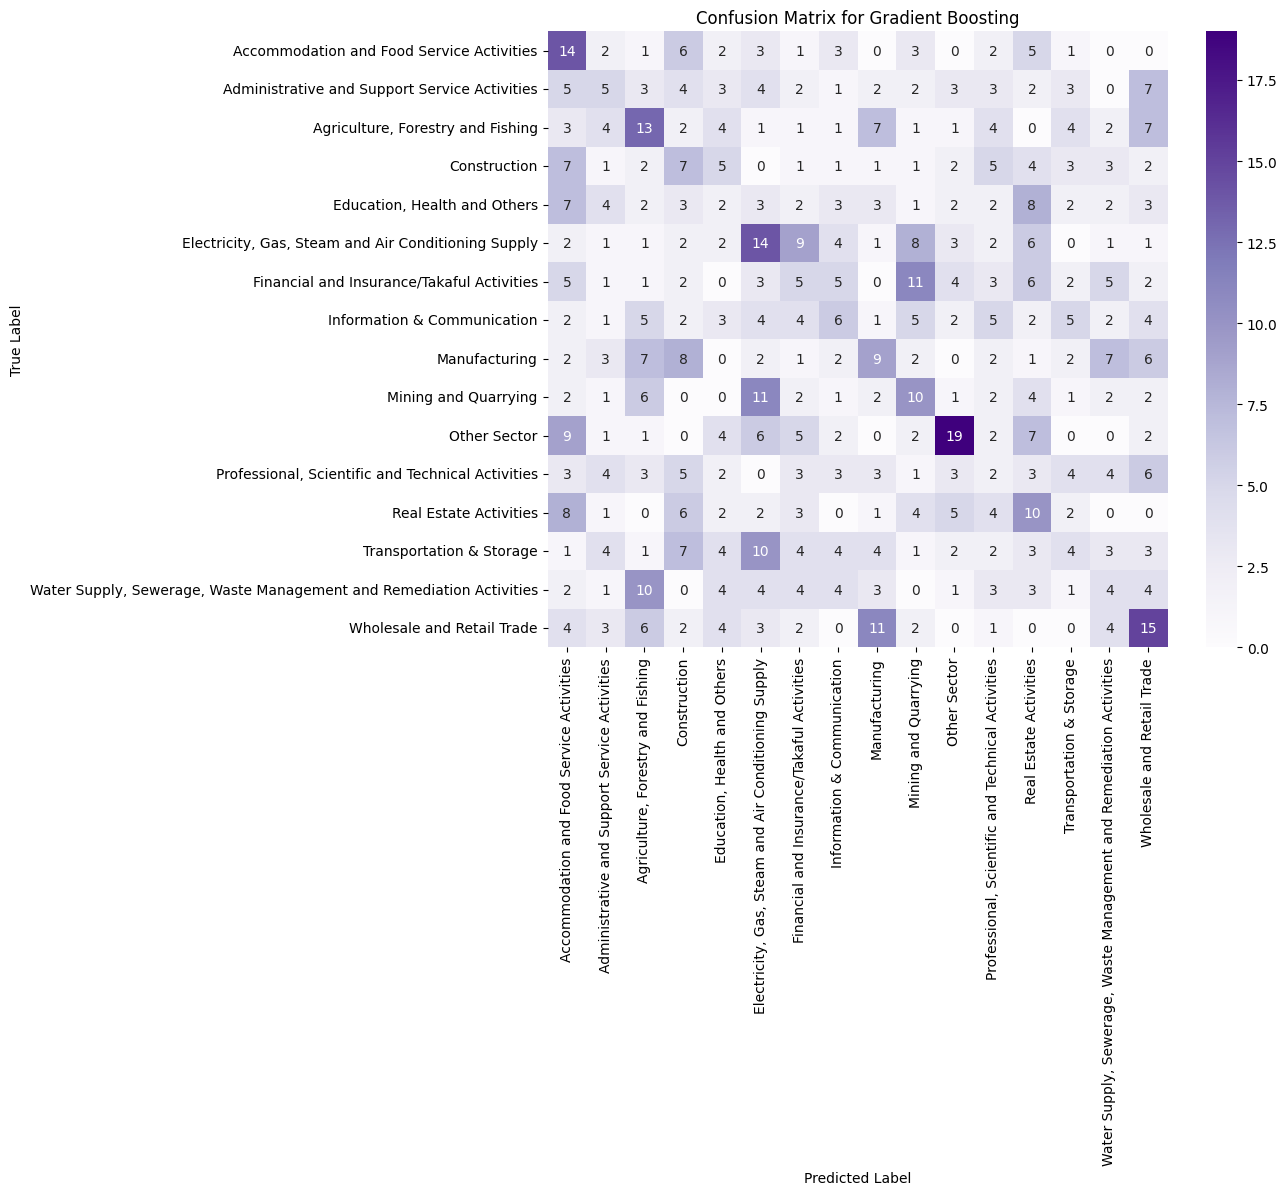

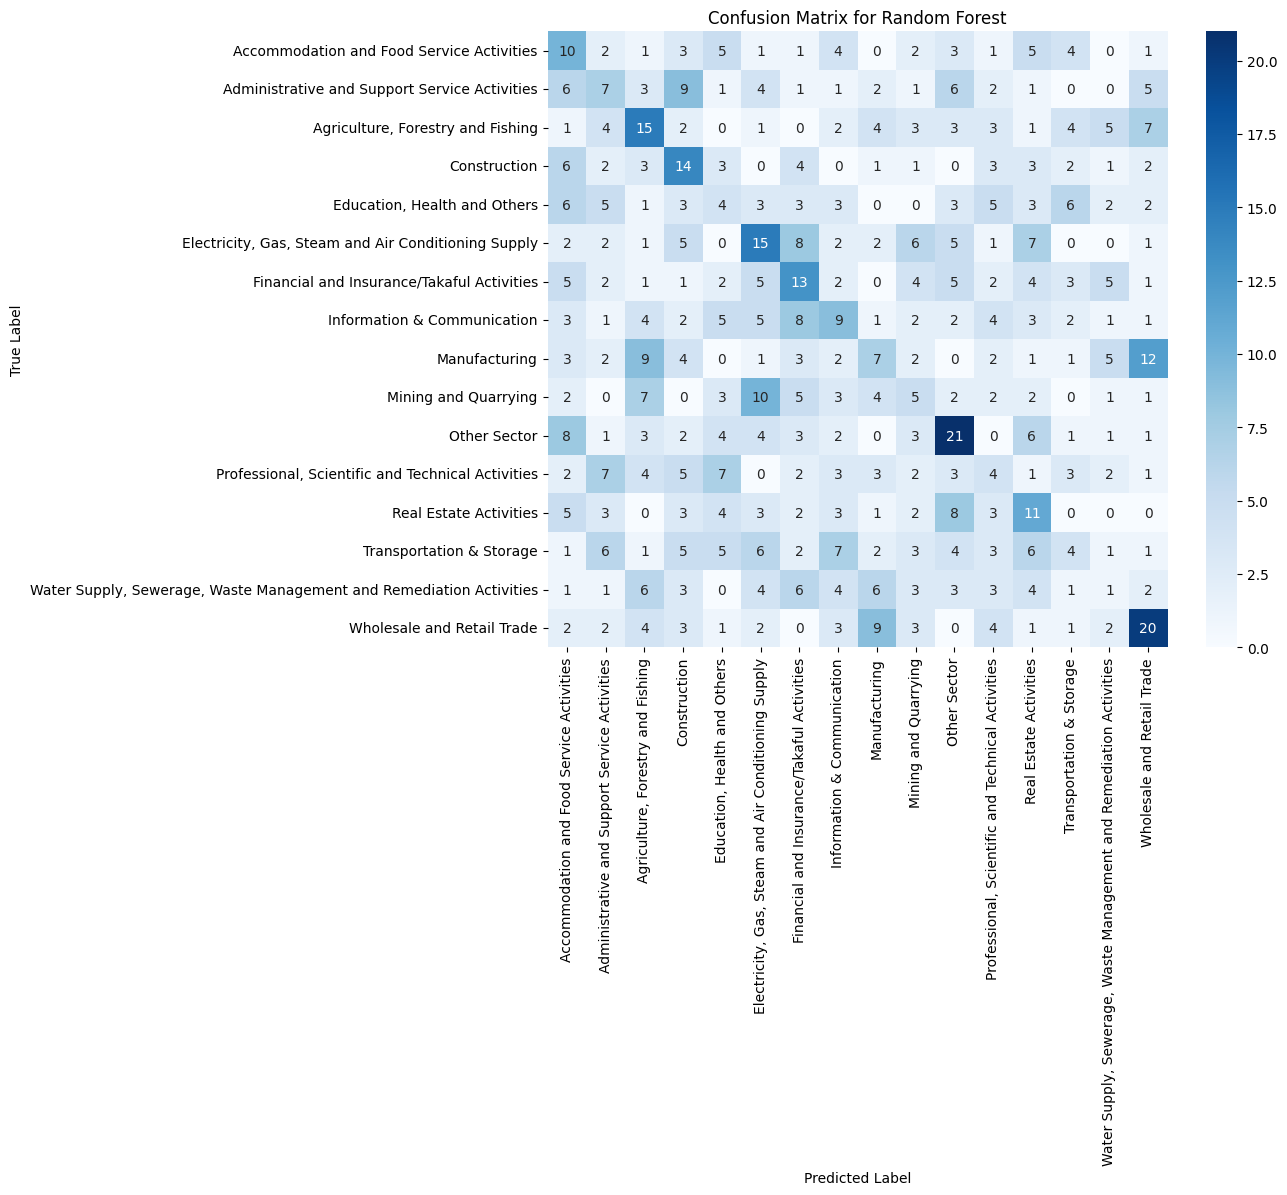

In [318]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already run the cell above and have y_test, y_pred_gb, and y_pred_rf defined

# Generate Confusion Matrix for Gradient Boosting
cm_gb = confusion_matrix(y_test, y_pred_gb)

# Plot Confusion Matrix for Gradient Boosting
plt.figure(figsize=(10, 8))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Gradient Boosting')
plt.show()

# Generate Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot Confusion Matrix for Random Forest
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest')
plt.show()


In [319]:
# @title **Load the 16 Economic Sectors GDPs**

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

# Load the file paths
file_paths = {
    "16_economic_sectors": "/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/16_Economic_Sectors.xlsx",
    }

# Define a cleaning function
def clean_data(file_path, skiprows=5):
    data = pd.read_excel(file_path, skiprows=skiprows)

    # Clean column names
    data.columns = data.columns.str.strip().str.replace(r'\n', '', regex=True)

    # Function to fill Year based on Quarter progression
    current_year = np.nan
    for i in range(len(data)):
        if not pd.isna(data.at[i, 'Year']):
            current_year = data.at[i, 'Year']
        elif not pd.isna(data.at[i, 'Quarter']):
            if data.at[i, 'Quarter'] == 1 and not pd.isna(current_year):
                current_year += 1
            data.at[i, 'Year'] = current_year

    # Remove rows with NaN values
    data = data.dropna().reset_index(drop=True)

    # Convert column 'Year' and 'Quarter' to integer
    data['Year'] = data['Year'].astype(int)
    data['Quarter'] = data['Quarter'].astype(int)

    # Convert Economic Sectors to numeric
    columns_to_convert = [
    'Agriculture, Forestry and Fishing',
    'Mining and Quarrying',
    'Manufacturing',
    'Electricity, Gas, Steam and Air Conditioning Supply',
    'Water Supply, Sewerage, Waste Management and Remediation Activities',
    'Construction',
    'Wholesale and Retail Trade',
    'Accommodation and Food Service Activities',
    'Transport and Storage',
    'Information & Communication',
    'Financial and Insurance/Takaful Activities',
    'Real Estate Activities',
    'Professional, Scientific and Technical Activities',
    'Administrative and Support Service Activities',
    'Education, Health and Others',
    'Other Sector',
    ]

    existing_columns_to_convert = [col for col in columns_to_convert if col in data.columns]
    data[existing_columns_to_convert] = data[existing_columns_to_convert].apply(pd.to_numeric, errors='coerce')

    # Replace common non-numeric entries with NaN
    data.replace(['N/A', '-', 'unknown', ''], pd.NA, inplace=True)

    # Drop the last 5 rows (to drop year 2025 from the datasets)
    #data = data.iloc[:-5, :]

    return data

# Apply cleaning to multiple files
cleaned_data = {}
for key, path in file_paths.items():
    cleaned_data[key] = clean_data(path)
    cleaned_data[key].to_excel(f'Cleaned_{key.capitalize()}_by_Sector.xlsx', index=False)

economic_sectors = cleaned_data['16_economic_sectors']

In [320]:
economic_sectors

Year  Quarter  Agriculture, Forestry and Fishing  Mining and Quarrying  \
0   2021        1                          30065.624             29823.144   
1   2021        2                          34742.632             32231.147   
2   2021        3                          40420.100             28643.878   
3   2021        4                          42923.685             33656.900   
4   2022        1                          38698.303             42941.056   
5   2022        2                          44132.942             47472.502   
6   2022        3                          40424.666             44715.904   
7   2022        4                          37311.345             43309.220   
8   2023        1                          31153.227             42277.025   
9   2023        2                          32678.540             38913.312   
10  2023        3                          40403.873             35638.150   
11  2023        4                          37693.947             39154.363   
12  2024        1                          32690.376             44968.537   
13  2024        2                          36502.767             42472.319   
14  2024        3                          43830.852             33598.802   
15  2024        4                          44612.530             34642.745   

    Manufacturing  Electricity, Gas, Steam and Air Conditioning Supply  \
0       85276.400                                           7724.250     
1       86697.129                                           7839.708     
2       89026.241                                           7767.620     
3      100825.761                                           8567.190     
4       97527.780                                           7936.776     
5      101880.338                                           8187.275     
6      108175.397                                           8467.847     
7      110954.383                                           8530.566     
8      103831.664                                           8000.928     
9      101332.030                                           8484.413     
10     105701.443                                           8654.485     
11     108718.994                                           8928.705     
12     104656.403                                           8748.990     
13     106610.770                                           9019.667     
14     111677.105                                           9125.324     
15     111487.482                                           9254.271     

    Water Supply, Sewerage, Waste Management and Remediation Activities  \
0                                            2191.465                     
1                                            2478.223                     
2                                            2574.840                     
3                                            2614.521                     
4                                            2270.808                     
5                                            2531.703                     
6                                            2778.374                     
7                                            2833.159                     
8                                            2442.143                     
9                                            2796.643                     
10                                           2916.406                     
11                                           2943.823                     
12                                           2597.477                     
13                                           2925.183                     
14                                           3074.842                     
15                                           3007.963                     

    Construction  Wholesale and Retail Trade  \
0      15080.630                   60416.385   
1      13841.368                   57694.779  

In [321]:
economic_sectors.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/economic_sectors.csv', index=False)

In [322]:
# @title **Comparison of Financial Ratios Rank versus GDP Rank**

import pandas as pd

# Load the uploaded datasets
ratios_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/wide_df.csv")
gdp_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/economic_sectors.csv")

# Aggregate financial ratios per sector using median values
sector_ratios = ratios_df.groupby('Sector')[['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']].median().reset_index()

# Reshape GDP data from wide to long format for aggregation
gdp_long = gdp_df.melt(id_vars=['Year', 'Quarter'], var_name='Sector', value_name='GDP')

# Aggregate GDP per sector (average GDP over all periods)
sector_gdp = gdp_long.groupby('Sector')['GDP'].mean().reset_index()

# Merge the financial ratios and GDP into one comparison table
sector_combined = pd.merge(sector_ratios, sector_gdp, on='Sector')

# Add a total financial score (simple sum of three ratios) for ranking
sector_combined['Total Financial Ratios'] = sector_combined[['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']].sum(axis=1)

# Rank sectors based on Financial Score and GDP
sector_combined['Financial Rank'] = sector_combined['Total Financial Ratios'].rank(ascending=False, method='min')
sector_combined['GDP Rank'] = sector_combined['GDP'].rank(ascending=False, method='min')
sector_combined['Mismatch'] = sector_combined['Financial Rank'] - sector_combined['GDP Rank']

# Rearrange the columns
sector_combined=sector_combined[['Sector','Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio', 'Total Financial Ratios', 'GDP', 'Financial Rank', 'GDP Rank', 'Mismatch']]

# Sort for display
sector_combined_sorted = sector_combined.sort_values('Financial Rank')

sector_combined_sorted


Sector  Approval Ratio  \
2                   Agriculture, Forestry and Fishing        0.416279   
8                                       Manufacturing        0.488410   
15                         Wholesale and Retail Trade        0.459648   
6          Financial and Insurance/Takaful Activities        0.423479   
14  Water Supply, Sewerage, Waste Management and R...        0.295164   
11  Professional, Scientific and Technical Activities        0.399294   
9                                Mining and Quarrying        0.309477   
3                                        Construction        0.488530   
1       Administrative and Support Service Activities        0.390852   
10                                       Other Sector        0.427130   
4                        Education, Health and Others        0.367627   
13                           Transportation & Storage        0.446339   
7                         Information & Communication        0.359128   
12                             Real Estate Activities        0.489153   
0           Accommodation and Food Service Activities        0.314526   
5   Electricity, Gas, Steam and Air Conditioning S...        0.292581   

    Disbursement Ratio  Repayment Ratio  Total Financial Ratios  \
2             3.716022         1.036524                5.168824   
8             3.256436         0.972165                4.717011   
15            3.003544         0.952213                4.415405   
6             2.187500         0.930890                3.541870   
14            2.211558         0.974791                3.481513   
11            1.867382         1.051754                3.318430   
9             2.081813         0.927065                3.318356   
3             1.715608         1.020062                3.224200   
1             1.820208         0.958105                3.169166   
10            1.343308         1.281535                3.051972   
4             1.446249         1.037867                2.851743   
13            1.400710         0.929358                2.776406   
7             1.452557         0.888278                2.699963   
12            1.064894         1.143855                2.697902   
0             1.168252         0.894038                2.376817   
5             0.691097         0.846363                1.830040   

              GDP  Financial Rank  GDP Rank  Mismatch  
2    38017.838062             1.0       5.0      -4.0  
8   102148.707500             2.0       1.0       1.0  
15   75603.294500             3.0       2.0       1.0  
6    27468.087250             4.0       6.0      -2.0  
14    2686.098313             5.0      16.0     -11.0  
11    9179.205187             6.0      12.0      -6.0  
9    38403.687750             7.0       4.0       3.0  
3    16281.340250             8.0       8.0       0.0  
1     3358.079688             9.0      15.0      -6.0  
10   45965.928562            10.0       3.0       7.0  
4     9674.467750            11.0      11.0       0.0  
13   15891.969313            12.0       9.0       3.0  
7    25720.996375            13.0       7.0       6.0  
12    5805.200250            14.0      14.0       0.0  
0    13939.673437            15.0      10.0       5.0  
5     8452.375938            16.0      13.0       3.0

In [323]:
sector_combined_sorted.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/sector_combined_sorted.csv', index=False)

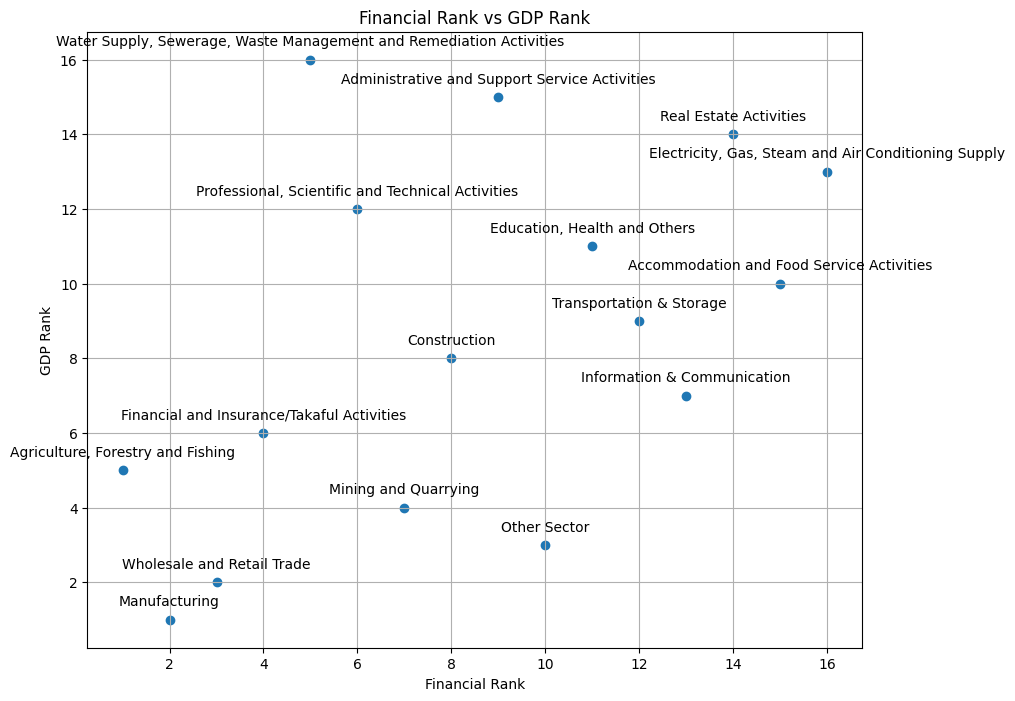

In [324]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(sector_combined['Financial Rank'], sector_combined['GDP Rank'])

# Add labels to the points
for i, sector in enumerate(sector_combined['Sector']):
    plt.annotate(sector, (sector_combined['Financial Rank'][i], sector_combined['GDP Rank'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Financial Rank')
plt.ylabel('GDP Rank')
plt.title('Financial Rank vs GDP Rank')
plt.grid(True)
plt.show()

In [325]:
# @title **Merged Dataset (Financial Ratios + GDP)**

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, make_scorer, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)


# Load datasets
ratios_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/wide_df.csv")
gdp_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/economic_sectors.csv")

# Preprocess data
ratios_df['Month'] = pd.to_datetime(ratios_df['Month'], format='%B').dt.month
ratios_df['Quarter'] = pd.cut(ratios_df['Month'], bins=[0, 3, 6, 9, 12], labels=[1, 2, 3, 4]).astype(int)

gdp_long = gdp_df.melt(id_vars=['Year', 'Quarter'], var_name='Sector', value_name='GDP')
merged_df = pd.merge(ratios_df, gdp_long, how='left', on=['Year', 'Quarter', 'Sector'])
merged_df.dropna(subset=['GDP'], inplace=True)

# Encode target
le = LabelEncoder()
merged_df['Sector_encoded'] = le.fit_transform(merged_df['Sector'])

In [326]:
merged_df

Year  Month Financial Institutions  \
0     2021      8       Commercial Banks   
1     2021      8       Commercial Banks   
2     2021      8       Commercial Banks   
3     2021      8       Commercial Banks   
4     2021      8       Commercial Banks   
...    ...    ...                    ...   
2683  2024      9          Islamic Banks   
2684  2024      9          Islamic Banks   
2685  2024      9          Islamic Banks   
2686  2024      9          Islamic Banks   
2687  2024      9          Islamic Banks   

                                                 Sector  Approval Ratio  \
0             Accommodation and Food Service Activities        0.358645   
1         Administrative and Support Service Activities        0.475414   
2                     Agriculture, Forestry and Fishing        0.278014   
3                                          Construction        0.554871   
4                          Education, Health and Others        0.274418   
...                                                 ...             ...   
2683  Professional, Scientific and Technical Activities        0.343133   
2684                             Real Estate Activities        0.366272   
2685                           Transportation & Storage        0.469348   
2686  Water Supply, Sewerage, Waste Management and R...        0.386641   
2687                         Wholesale and Retail Trade        0.364256   

      Disbursement Ratio  Repayment Ratio  Quarter        GDP  Sector_encoded  
0               4.262370         1.156818        3   9063.034               0  
1               4.694815         0.914110        3   2431.661               1  
2               6.569846         0.957584        3  40420.100               2  
3               1.692577         1.225313        3  12928.958               3  
4               2.904152         1.322109        3   6898.414               4  
...                  ...              ...      ...        ...             ...  
2683            1.654831         1.054880        3  10636.972              11  
2684            1.427039         0.676947        3   7217.093              12  
2685            3.267331         0.876897        3  19123.044              13  
2686            4.198255         0.976527        3   3074.842              14  
2687            4.091884         0.919820        3  87572.079              15  

[2688 rows x 10 columns]

In [327]:

# Define features (X) and target (y)
X = merged_df[['Approval Ratio', 'Disbursement Ratio', 'Repayment Ratio']]
y = merged_df['Sector']

# Encode the target variable if it's categorical (assuming 'Target' is numeric based on provided info, but keeping this just in case)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred, target_names=le.classes_)

importances = rf.feature_importances_
normalized_importances = importances / importances.sum()

# Calculate Sector Score using normalized importances
merged_df['Sector Score'] = (
    normalized_importances[0] * merged_df['Approval Ratio'] +
    normalized_importances[1] * merged_df['Disbursement Ratio'] +
    normalized_importances[2] * merged_df['Repayment Ratio']
)

merged_df

Year  Month Financial Institutions  \
0     2021      8       Commercial Banks   
1     2021      8       Commercial Banks   
2     2021      8       Commercial Banks   
3     2021      8       Commercial Banks   
4     2021      8       Commercial Banks   
...    ...    ...                    ...   
2683  2024      9          Islamic Banks   
2684  2024      9          Islamic Banks   
2685  2024      9          Islamic Banks   
2686  2024      9          Islamic Banks   
2687  2024      9          Islamic Banks   

                                                 Sector  Approval Ratio  \
0             Accommodation and Food Service Activities        0.358645   
1         Administrative and Support Service Activities        0.475414   
2                     Agriculture, Forestry and Fishing        0.278014   
3                                          Construction        0.554871   
4                          Education, Health and Others        0.274418   
...                                                 ...             ...   
2683  Professional, Scientific and Technical Activities        0.343133   
2684                             Real Estate Activities        0.366272   
2685                           Transportation & Storage        0.469348   
2686  Water Supply, Sewerage, Waste Management and R...        0.386641   
2687                         Wholesale and Retail Trade        0.364256   

      Disbursement Ratio  Repayment Ratio  Quarter        GDP  Sector_encoded  \
0               4.262370         1.156818        3   9063.034               0   
1               4.694815         0.914110        3   2431.661               1   
2               6.569846         0.957584        3  40420.100               2   
3               1.692577         1.225313        3  12928.958               3   
4               2.904152         1.322109        3   6898.414               4   
...                  ...              ...      ...        ...             ...   
2683            1.654831         1.054880        3  10636.972              11   
2684            1.427039         0.676947        3   7217.093              12   
2685            3.267331         0.876897        3  19123.044              13   
2686            4.198255         0.976527        3   3074.842              14   
2687            4.091884         0.919820        3  87572.079              15   

      Sector Score  
0         1.838004  
1         1.888998  
2         2.397010  
3         1.177456  
4         1.493986  
...            ...  
2683      1.034160  
2684      0.809269  
2685      1.457729  
2686      1.748255  
2687      1.686543  

[2688 rows x 11 columns]

In [328]:
merged_df.to_csv("/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/merged_df.csv", index=False)

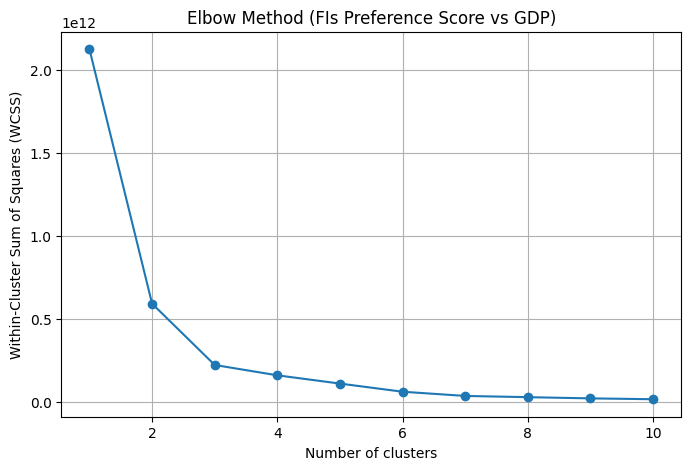

In [329]:
# @title **Elbow Method for Clustering Analysis**

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Select the features for clustering
X_cluster_gdp = merged_df[['Sector Score', 'GDP']]

# Determine the optimal number of clusters (Elbow method - optional but recommended)
inertia_gdp = []
for i in range(1, 11):
    kmeans_gdp = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans_gdp.fit(X_cluster_gdp)
    inertia_gdp.append(kmeans_gdp.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia_gdp, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method (FIs Preference Score vs GDP)')
plt.grid(True)
plt.show()


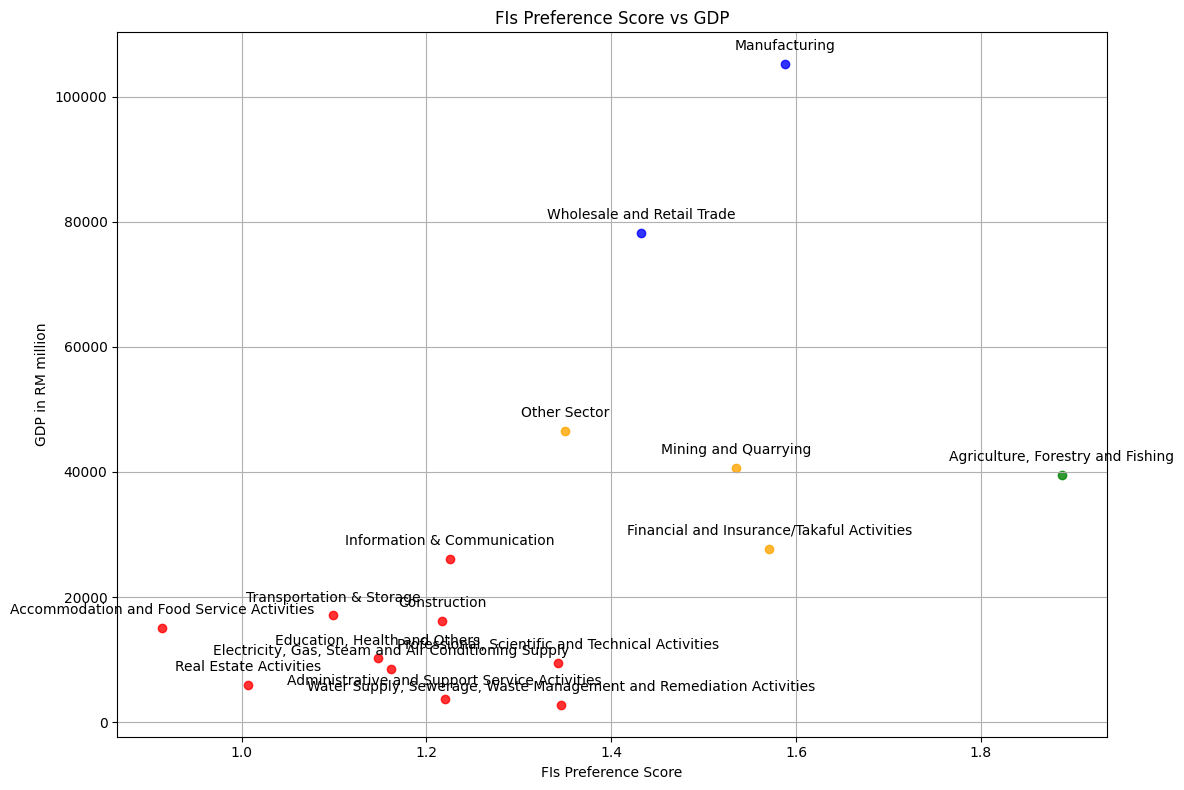

In [330]:
# @title **Clustering Analysis Sector Score vs GDP**

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Reload the uploaded file
merged_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/merged_df.csv")

# Re-aggregate the Sector Score and GDP by sector using median
sector_score = merged_df.groupby('Sector')[['Sector Score']].median().reset_index()
sector_gdp = merged_df.groupby('Sector')['GDP'].median().reset_index()

# Merge the two dataframes on Sector
sector_combined = pd.merge(sector_score, sector_gdp, on='Sector')

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(sector_combined[['Sector Score', 'GDP']])

# Apply KMeans clustering with k=4 as per user reference
kmeans_sector = KMeans(n_clusters=4, random_state=42, n_init=10)
sector_combined['Cluster'] = kmeans_sector.fit_predict(scaled_features)

# Assign colors
cluster_palette = ['red', 'orange','green', 'blue']
sector_combined['Color'] = sector_combined['Cluster'].map(lambda x: cluster_palette[x])

# Plot with annotations
plt.figure(figsize=(12, 8))
for color in sector_combined['Color'].unique():
    subset = sector_combined[sector_combined['Color'] == color]
    plt.scatter(subset['Sector Score'], subset['GDP'], color=color, label=f'Cluster {color}', alpha=0.8)

# Annotate each sector
for _, row in sector_combined.iterrows():
    plt.annotate(row['Sector'], (row['Sector Score'], row['GDP']), textcoords="offset points", xytext=(0, 10), ha='center')

plt.xlabel('FIs Preference Score')
plt.ylabel('GDP in RM million')
plt.title('FIs Preference Score vs GDP')
plt.grid(True)
plt.tight_layout()
plt.show()


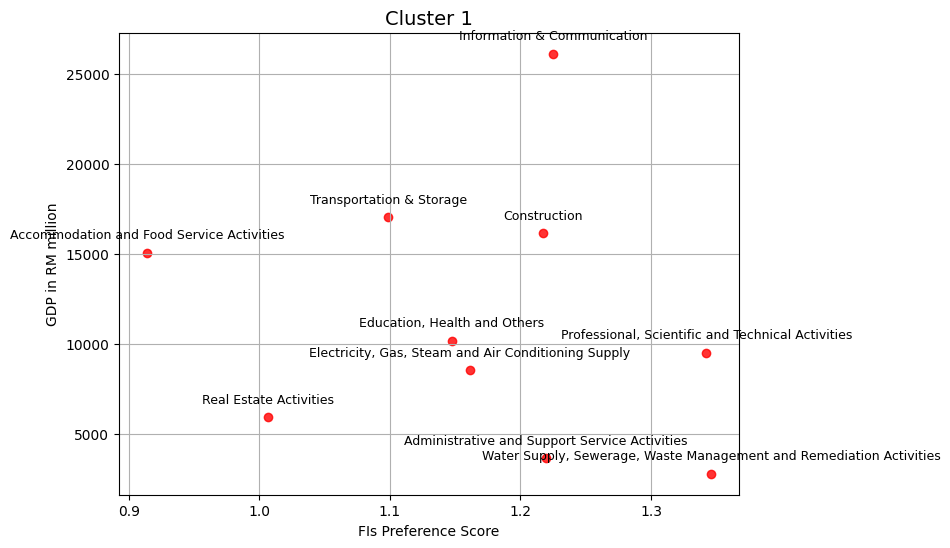

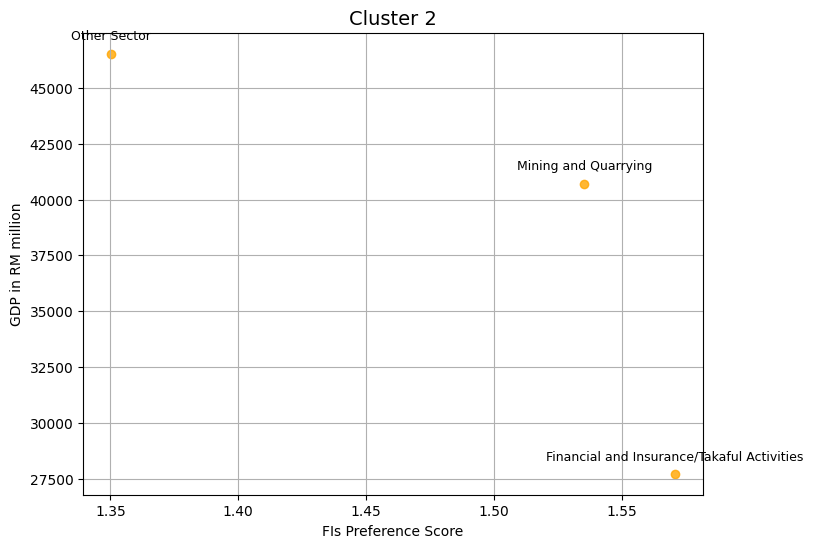

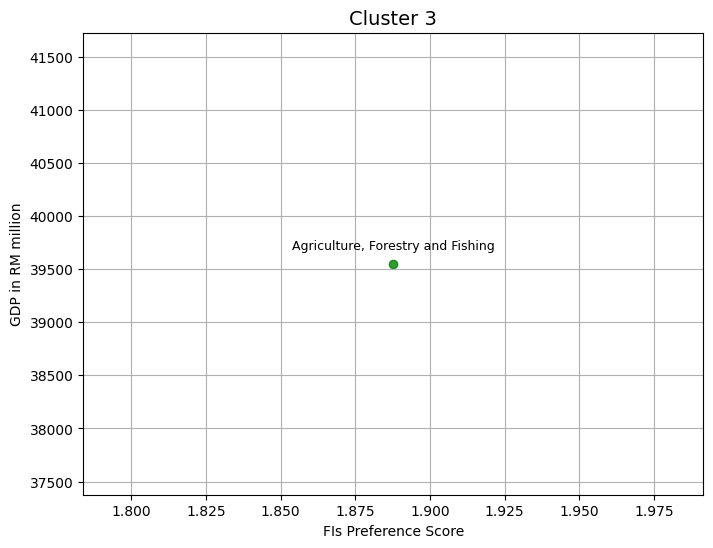

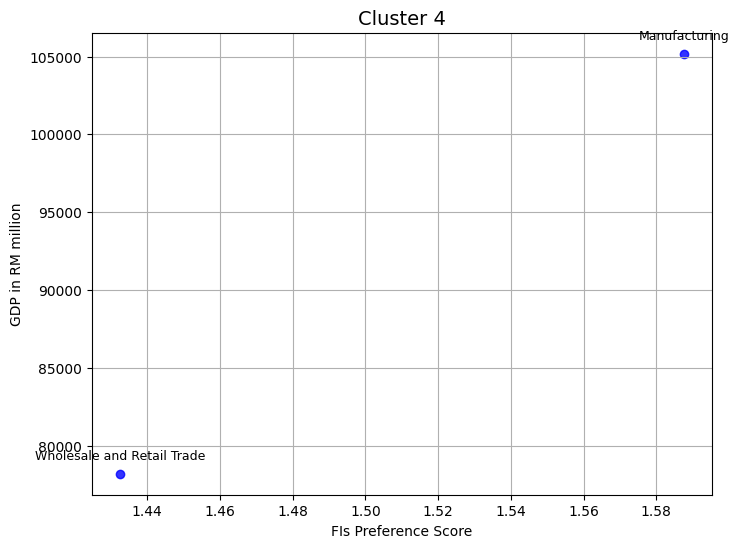

In [336]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load dataset
merged_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/merged_df.csv")

# Aggregate Sector Score and GDP by sector (median)
sector_score = merged_df.groupby('Sector')[['Sector Score']].median().reset_index()
sector_gdp = merged_df.groupby('Sector')['GDP'].median().reset_index()
sector_combined = pd.merge(sector_score, sector_gdp, on='Sector')

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(sector_combined[['Sector Score', 'GDP']])

# KMeans clustering with scaled data
kmeans_sector = KMeans(n_clusters=4, random_state=42, n_init=10)
sector_combined['Cluster'] = kmeans_sector.fit_predict(scaled_features)

# Assign cluster colors
cluster_palette = ['red', 'orange','green', 'blue']
sector_combined['Color'] = sector_combined['Cluster'].map(lambda x: cluster_palette[x])

# Generate separate plots for each cluster
for cluster in sorted(sector_combined['Cluster'].unique()):
    subset = sector_combined[sector_combined['Cluster'] == cluster]
    color = cluster_palette[cluster]

    plt.figure(figsize=(8, 6))
    plt.scatter(subset['Sector Score'], subset['GDP'], color=color, alpha=0.8)

    for _, row in subset.iterrows():
        plt.annotate(row['Sector'], (row['Sector Score'], row['GDP']),
                     textcoords="offset points", xytext=(0, 10), ha='center', fontsize=9)

    plt.xlabel('FIs Preference Score')
    plt.ylabel('GDP in RM million')
    plt.title(f'Cluster {cluster + 1}', fontsize=14)
    plt.grid(True)

    #plt.tight_layout()
    plt.show()


In [332]:
merged_df

Year  Month Financial Institutions  \
0     2021      8       Commercial Banks   
1     2021      8       Commercial Banks   
2     2021      8       Commercial Banks   
3     2021      8       Commercial Banks   
4     2021      8       Commercial Banks   
...    ...    ...                    ...   
2683  2024      9          Islamic Banks   
2684  2024      9          Islamic Banks   
2685  2024      9          Islamic Banks   
2686  2024      9          Islamic Banks   
2687  2024      9          Islamic Banks   

                                                 Sector  Approval Ratio  \
0             Accommodation and Food Service Activities        0.358645   
1         Administrative and Support Service Activities        0.475414   
2                     Agriculture, Forestry and Fishing        0.278014   
3                                          Construction        0.554871   
4                          Education, Health and Others        0.274418   
...                                                 ...             ...   
2683  Professional, Scientific and Technical Activities        0.343133   
2684                             Real Estate Activities        0.366272   
2685                           Transportation & Storage        0.469348   
2686  Water Supply, Sewerage, Waste Management and R...        0.386641   
2687                         Wholesale and Retail Trade        0.364256   

      Disbursement Ratio  Repayment Ratio  Quarter        GDP  Sector_encoded  \
0               4.262370         1.156818        3   9063.034               0   
1               4.694815         0.914110        3   2431.661               1   
2               6.569846         0.957584        3  40420.100               2   
3               1.692577         1.225313        3  12928.958               3   
4               2.904152         1.322109        3   6898.414               4   
...                  ...              ...      ...        ...             ...   
2683            1.654831         1.054880        3  10636.972              11   
2684            1.427039         0.676947        3   7217.093              12   
2685            3.267331         0.876897        3  19123.044              13   
2686            4.198255         0.976527        3   3074.842              14   
2687            4.091884         0.919820        3  87572.079              15   

      Sector Score  
0         1.838004  
1         1.888998  
2         2.397010  
3         1.177456  
4         1.493986  
...            ...  
2683      1.034160  
2684      0.809269  
2685      1.457729  
2686      1.748255  
2687      1.686543  

[2688 rows x 11 columns]

In [333]:
# Create the 'Total Financial Ratios' column by summing the specified columns
merged_df['Total Financial Ratios'] = merged_df['Approval Ratio'] + merged_df['Disbursement Ratio'] + merged_df['Repayment Ratio']

In [334]:
# Re-arrange column order
new_order = [
    'Year',
    'Month',
    'Quarter',
    'Financial Institutions',
    'Sector',
    'Approval Ratio',
    'Disbursement Ratio',
    'Repayment Ratio',
    'Total Financial Ratios',
    'Sector Score',
    'GDP',
    'Sector_encoded'
]

# Reindex the DataFrame to rearrange columns
merged_df = merged_df.reindex(columns=new_order)

merged_df

Year  Month  Quarter Financial Institutions  \
0     2021      8        3       Commercial Banks   
1     2021      8        3       Commercial Banks   
2     2021      8        3       Commercial Banks   
3     2021      8        3       Commercial Banks   
4     2021      8        3       Commercial Banks   
...    ...    ...      ...                    ...   
2683  2024      9        3          Islamic Banks   
2684  2024      9        3          Islamic Banks   
2685  2024      9        3          Islamic Banks   
2686  2024      9        3          Islamic Banks   
2687  2024      9        3          Islamic Banks   

                                                 Sector  Approval Ratio  \
0             Accommodation and Food Service Activities        0.358645   
1         Administrative and Support Service Activities        0.475414   
2                     Agriculture, Forestry and Fishing        0.278014   
3                                          Construction        0.554871   
4                          Education, Health and Others        0.274418   
...                                                 ...             ...   
2683  Professional, Scientific and Technical Activities        0.343133   
2684                             Real Estate Activities        0.366272   
2685                           Transportation & Storage        0.469348   
2686  Water Supply, Sewerage, Waste Management and R...        0.386641   
2687                         Wholesale and Retail Trade        0.364256   

      Disbursement Ratio  Repayment Ratio  Total Financial Ratios  \
0               4.262370         1.156818                5.777833   
1               4.694815         0.914110                6.084340   
2               6.569846         0.957584                7.805443   
3               1.692577         1.225313                3.472761   
4               2.904152         1.322109                4.500679   
...                  ...              ...                     ...   
2683            1.654831         1.054880                3.052844   
2684            1.427039         0.676947                2.470258   
2685            3.267331         0.876897                4.613576   
2686            4.198255         0.976527                5.561423   
2687            4.091884         0.919820                5.375960   

      Sector Score        GDP  Sector_encoded  
0         1.838004   9063.034               0  
1         1.888998   2431.661               1  
2         2.397010  40420.100               2  
3         1.177456  12928.958               3  
4         1.493986   6898.414               4  
...            ...        ...             ...  
2683      1.034160  10636.972              11  
2684      0.809269   7217.093              12  
2685      1.457729  19123.044              13  
2686      1.748255   3074.842              14  
2687      1.686543  87572.079              15  

[2688 rows x 12 columns]

In [335]:
merged_df.to_csv("/content/drive/MyDrive/Colab Notebooks/data/Jan_2025/Financial_Ratios_Data.csv", index=False)